In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

2025-03-08 23:55:56.759239: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 23:55:56.760656: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 23:55:56.764374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 23:55:56.774839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741458356.793199  128082 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741458356.79

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape data
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# One-hot encoding
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

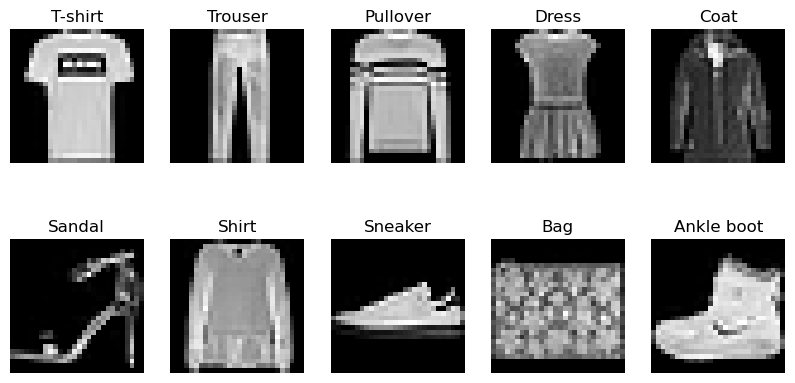

In [4]:
# Display one sample per class
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    sample_idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()


In [5]:
class NeuralNetwork:
    def __init__(self, layers, activation="relu", weight_init="random"):
        """
        Initializes the neural network.
        :param layers: List representing the number of neurons in each layer.
        :param activation: Activation function to use ('relu', 'sigmoid', 'tanh').
        :param weight_init: Weight initialization method ('random', 'xavier').
        """
        self.layers = layers
        self.activation = activation
        self.weight_init = weight_init
        self.weights, self.biases = self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights and biases based on the selected method."""
        np.random.seed(42)
        weights, biases = [], []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
                w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            else:  # Default: Random small values
                w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            
            b = np.zeros((1, self.layers[i+1]))
            weights.append(w)
            biases.append(b)
        
        return weights, biases

    def _activation(self, x, derivative=False):
        """Applies the selected activation function."""
        if self.activation == "relu":
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        elif self.activation == "tanh":
            t = np.tanh(x)
            return 1 - t**2 if derivative else t
        else:  # Default: Sigmoid
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig) if derivative else sig

    def forward(self, X):
        """Performs forward propagation."""
        activations, zs = [X], []

        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            zs.append(z)
            activations.append(self._activation(z))
        
        return activations, zs

    def backward(self, y_true, activations, zs, learning_rate):
        """Performs backpropagation and computes gradients."""
        grads_w, grads_b = [], []
        m = y_true.shape[0]
        
        # Compute loss gradient (assuming MSE loss)
        dA = activations[-1] - y_true  

        for i in reversed(range(len(self.weights))):
            dz = dA * self._activation(zs[i], derivative=True)
            dw = np.dot(activations[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            dA = np.dot(dz, self.weights[i].T)

            grads_w.insert(0, dw)
            grads_b.insert(0, db)

        return grads_w, grads_b

    # def update_weights(self, grads_w, grads_b, optimizer):
    #     """Updates weights and biases using the selected optimizer."""
    #     self.weights, self.biases = optimizer.update(self.weights, self.biases, grads_w, grads_b)


In [6]:
# Optimizers
class Optimizer:
    def __init__(self, method= None, lr=None, beta=0.9, beta2=0.999, epsilon=1e-8):
        self.method = method
        self.lr = lr
        self.beta = beta  # Used for momentum-based optimizers
        self.beta2 = beta2  # Used for RMSprop, Adam, Nadam
        self.epsilon = epsilon  # Prevents division by zero
        self.m_w = None  # First moment vector for weights
        self.v_w = None  # Second moment vector for weights
        self.m_b = None  # First moment vector for biases
        self.v_b = None  # Second moment vector for biases
        self.t = 0  # Time step for bias correction

    def update(self, weights, biases, grads_w, grads_b):
        if self.method == "sgd":
            weights = [w - self.lr * dw for w, dw in zip(weights, grads_w)]
            biases = [b - self.lr * db for b, db in zip(biases, grads_b)]

        elif self.method in ["momentum", "nesterov"]:
            if self.m_w is None:  # Initialize momentum terms
                self.m_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]

            for i in range(len(weights)):
                if self.method == "nesterov":
                    # Look-ahead step
                    look_ahead_w = weights[i] - self.beta * self.m_w[i]
                    look_ahead_b = biases[i] - self.beta * self.m_b[i]

                    # Compute gradients at look-ahead position
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]

                    weights[i] = look_ahead_w - self.m_w[i]
                    biases[i] = look_ahead_b - self.m_b[i]

                else:  # Normal momentum
                    self.m_w[i] = self.beta * self.m_w[i] + self.lr * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + self.lr * grads_b[i]
                    weights[i] -= self.m_w[i]
                    biases[i] -= self.m_b[i]

        elif self.method in ["rmsprop", "adam", "nadam"]:
            if self.m_w is None:  # Initialize moment estimates
                self.m_w = [np.zeros_like(w) for w in weights]
                self.v_w = [np.zeros_like(w) for w in weights]
                self.m_b = [np.zeros_like(b) for b in biases]
                self.v_b = [np.zeros_like(b) for b in biases]

            self.t += 1  # Update time step

            for i in range(len(weights)):
                if self.method == "rmsprop":
                    # Update second moment estimate (squared gradient)
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grads_w[i] ** 2
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grads_b[i] ** 2

                    # Update weights and biases
                    weights[i] -= self.lr * grads_w[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                    biases[i] -= self.lr * grads_b[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

                elif self.method in ["adam", "nadam"]:
                    # Compute biased first moment estimate
                    self.m_w[i] = self.beta * self.m_w[i] + (1 - self.beta) * grads_w[i]
                    self.m_b[i] = self.beta * self.m_b[i] + (1 - self.beta) * grads_b[i]

                    # Compute biased second moment estimate
                    self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
                    self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

                    # Bias correction
                    m_hat_w = self.m_w[i] / (1 - self.beta ** self.t)
                    v_hat_w = self.v_w[i] / (1 - self.beta2 ** self.t)
                    m_hat_b = self.m_b[i] / (1 - self.beta ** self.t)
                    v_hat_b = self.v_b[i] / (1 - self.beta2 ** self.t)

                    if self.method == "adam":
                        # Adam update rule
                        weights[i] -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

                    elif self.method == "nadam":
                        # Nadam additional momentum correction
                        nadam_m_w = self.beta * m_hat_w + (1 - self.beta) * grads_w[i] / (1 - self.beta ** self.t)
                        nadam_m_b = self.beta * m_hat_b + (1 - self.beta) * grads_b[i] / (1 - self.beta ** self.t)

                        weights[i] -= self.lr * nadam_m_w / (np.sqrt(v_hat_w) + self.epsilon)
                        biases[i] -= self.lr * nadam_m_b / (np.sqrt(v_hat_b) + self.epsilon)

        return weights, biases

In [12]:
def train():
    # Initialize wandb for logging
    wandb.init(project="Assignment_Attempt2")
    config = wandb.config

    wandb.init(project="Assignment_Attempt2",  name=f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}")

    # Extract hyperparameters from WandB
    layers = [784] + [config.hidden_size] * config.hidden_layers + [10]
    activation = config.activation
    weight_init = config.weight_init
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    optimizer = config.optimizer
    epochs = config.epochs

    # Initialize Neural Network
    model = NeuralNetwork(layers, activation=activation, weight_init=weight_init)
    optimizer = Optimizer(method=optimizer, lr=learning_rate)

    for epoch in range(epochs):
        num_batches = len(X_train) // batch_size
        train_loss, train_acc = 0, 0

        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            X_batch, y_batch = X_train[start:end], y_train_one_hot[start:end]

            # Forward propagation
            activations, zs = model.forward(X_batch)
            preds = np.argmax(activations[-1], axis=1)
            y_true_labels = np.argmax(y_batch, axis=1)

            # Compute loss and accuracy
            batch_loss = np.mean((activations[-1] - y_batch) ** 2)
            batch_acc = np.mean(preds == y_true_labels)

            train_loss += batch_loss
            train_acc += batch_acc

            # Backpropagation
            grads_w, grads_b = model.backward(y_batch, activations, zs, learning_rate)
            model.weights, model.biases = optimizer.update(model.weights, model.biases, grads_w, grads_b)

        # Average loss and accuracy
        train_loss /= num_batches
        train_acc /= num_batches

        # Validation phase
        val_activations, _ = model.forward(X_test)
        val_preds = np.argmax(val_activations[-1], axis=1)
        val_true_labels = np.argmax(y_test_one_hot, axis=1)

        val_loss = np.mean((val_activations[-1] - y_test_one_hot) ** 2)
        val_acc = np.mean(val_preds == val_true_labels)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


In [8]:
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficiency
    'metric': {'name': 'val_loss', 'goal': 'minimize'},  # Optimize for lowest validation loss
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

In [13]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_Attempt2")
wandb.agent(sweep_id, train, count=200)  # Runs 20 different hyperparameter combinations

Create sweep with ID: 3d7x5ek1
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/Assignment_Attempt2/sweeps/3d7x5ek1


wandb: Agent Starting Run: 9a92fz1j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0931, Train Acc=0.1013, Val Loss=0.0930, Val Acc=0.1000
Epoch 2: Train Loss=0.0930, Train Acc=0.1016, Val Loss=0.0930, Val Acc=0.1000
Epoch 3: Train Loss=0.0930, Train Acc=0.1016, Val Loss=0.0930, Val Acc=0.1000
Epoch 4: Train Loss=0.0930, Train Acc=0.1016, Val Loss=0.0930, Val Acc=0.1000
Epoch 5: Train Loss=0.0930, Train Acc=0.1016, Val Loss=0.0930, Val Acc=0.1000
Epoch 6: Train Loss=0.0930, Train Acc=0.1017, Val Loss=0.0930, Val Acc=0.1000
Epoch 7: Train Loss=0.0930, Train Acc=0.1017, Val Loss=0.0930, Val Acc=0.1000
Epoch 8: Train Loss=0.0930, Train Acc=0.1017, Val Loss=0.0930, Val Acc=0.1000
Epoch 9: Train Loss=0.0930, Train Acc=0.1017, Val Loss=0.0930, Val Acc=0.1000
Epoch 10: Train Loss=0.0930, Train Acc=0.1017, Val Loss=0.0930, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▁▁▅▅▅▁▁
epoch,10
train_accuracy,0.10165
train_loss,0.09302
val_accuracy,0.1
val_loss,0.09303


wandb: Agent Starting Run: mz10gchr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0301, Train Acc=0.8255, Val Loss=0.0246, Val Acc=0.8423
Epoch 2: Train Loss=0.0226, Train Acc=0.8601, Val Loss=0.0249, Val Acc=0.8382
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0239, Val Acc=0.8427
Epoch 4: Train Loss=0.0195, Train Acc=0.8772, Val Loss=0.0230, Val Acc=0.8534
Epoch 5: Train Loss=0.0189, Train Acc=0.8802, Val Loss=0.0226, Val Acc=0.8504


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▃▂▁▁
val_accuracy,▃▁▃█▇
val_loss,▇█▅▂▁
epoch,5
train_accuracy,0.88017
train_loss,0.01888
val_accuracy,0.8504
val_loss,0.02263


wandb: Agent Starting Run: wnanq5mr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0957, Train Acc=0.0966, Val Loss=0.0950, Val Acc=0.1000
Epoch 2: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 3: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 4: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 5: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 6: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 7: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 8: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 9: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000
Epoch 10: Train Loss=0.0950, Train Acc=0.0976, Val Loss=0.0950, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,0.09762
train_loss,0.095
val_accuracy,0.1
val_loss,0.095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nk1vm0j8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0393, Train Acc=0.7858, Val Loss=0.0316, Val Acc=0.8200
Epoch 2: Train Loss=0.0278, Train Acc=0.8400, Val Loss=0.0278, Val Acc=0.8392
Epoch 3: Train Loss=0.0246, Train Acc=0.8552, Val Loss=0.0257, Val Acc=0.8499
Epoch 4: Train Loss=0.0226, Train Acc=0.8644, Val Loss=0.0243, Val Acc=0.8554
Epoch 5: Train Loss=0.0213, Train Acc=0.8709, Val Loss=0.0233, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87092
train_loss,0.02126
val_accuracy,0.8609
val_loss,0.02326


wandb: Agent Starting Run: qv7qnx2z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0878, Train Acc=0.2882, Val Loss=0.0666, Val Acc=0.5302
Epoch 2: Train Loss=0.0507, Train Acc=0.6611, Val Loss=0.0407, Val Acc=0.7436
Epoch 3: Train Loss=0.0344, Train Acc=0.7761, Val Loss=0.0312, Val Acc=0.7861
Epoch 4: Train Loss=0.0282, Train Acc=0.8119, Val Loss=0.0276, Val Acc=0.8133
Epoch 5: Train Loss=0.0253, Train Acc=0.8306, Val Loss=0.0257, Val Acc=0.8244
Epoch 6: Train Loss=0.0236, Train Acc=0.8403, Val Loss=0.0245, Val Acc=0.8314
Epoch 7: Train Loss=0.0225, Train Acc=0.8478, Val Loss=0.0237, Val Acc=0.8379
Epoch 8: Train Loss=0.0217, Train Acc=0.8529, Val Loss=0.0231, Val Acc=0.8414
Epoch 9: Train Loss=0.0210, Train Acc=0.8579, Val Loss=0.0225, Val Acc=0.8436
Epoch 10: Train Loss=0.0204, Train Acc=0.8616, Val Loss=0.0221, Val Acc=0.8469


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.86162
train_loss,0.02045
val_accuracy,0.8469
val_loss,0.02213


wandb: Agent Starting Run: 14kpst7n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0464, Train Acc=0.7565, Val Loss=0.0361, Val Acc=0.8007
Epoch 2: Train Loss=0.0321, Train Acc=0.8260, Val Loss=0.0310, Val Acc=0.8196
Epoch 3: Train Loss=0.0285, Train Acc=0.8407, Val Loss=0.0286, Val Acc=0.8328
Epoch 4: Train Loss=0.0264, Train Acc=0.8505, Val Loss=0.0270, Val Acc=0.8396
Epoch 5: Train Loss=0.0249, Train Acc=0.8577, Val Loss=0.0258, Val Acc=0.8459


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.85772
train_loss,0.02488
val_accuracy,0.8459
val_loss,0.0258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 69t5ygu2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0728, Train Acc=0.4418, Val Loss=0.0455, Val Acc=0.7088
Epoch 2: Train Loss=0.0357, Train Acc=0.7661, Val Loss=0.0306, Val Acc=0.7893
Epoch 3: Train Loss=0.0272, Train Acc=0.8177, Val Loss=0.0266, Val Acc=0.8189
Epoch 4: Train Loss=0.0242, Train Acc=0.8367, Val Loss=0.0247, Val Acc=0.8295
Epoch 5: Train Loss=0.0225, Train Acc=0.8471, Val Loss=0.0236, Val Acc=0.8371


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.84713
train_loss,0.02254
val_accuracy,0.8371
val_loss,0.02356


wandb: Agent Starting Run: fgh5jlcd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0461, Train Acc=0.7509, Val Loss=0.0353, Val Acc=0.8042
Epoch 2: Train Loss=0.0313, Train Acc=0.8268, Val Loss=0.0305, Val Acc=0.8222
Epoch 3: Train Loss=0.0278, Train Acc=0.8413, Val Loss=0.0281, Val Acc=0.8327
Epoch 4: Train Loss=0.0258, Train Acc=0.8501, Val Loss=0.0266, Val Acc=0.8412
Epoch 5: Train Loss=0.0244, Train Acc=0.8575, Val Loss=0.0255, Val Acc=0.8463


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.85752
train_loss,0.02438
val_accuracy,0.8463
val_loss,0.02546


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mjk10upi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691
Epoch 6: Train Loss=0.0158, Train Acc=0.8940, Val Loss=0.0186, Val Acc=0.8703
Epoch 7: Train Loss=0.0151, Train Acc=0.8989, Val Loss=0.0182, Val Acc=0.8726
Epoch 8: Train Loss=0.0145, Train Acc=0.9031, Val Loss=0.0179, Val Acc=0.8752
Epoch 9: Train Loss=0.0140, Train Acc=0.9069, Val Loss=0.0180, Val Acc=0.8750
Epoch 10: Train Loss=0.0136, Train Acc=0.9103, Val Loss=0.0184, Val Acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇██▇
val_loss,█▆▄▃▂▂▁▁▁▂
epoch,10
train_accuracy,0.91035
train_loss,0.01364
val_accuracy,0.8725
val_loss,0.01838


wandb: Agent Starting Run: 917woig5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Agent Starting Run: pqq1ibj5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0878, Train Acc=0.2882, Val Loss=0.0666, Val Acc=0.5302
Epoch 2: Train Loss=0.0507, Train Acc=0.6611, Val Loss=0.0407, Val Acc=0.7436
Epoch 3: Train Loss=0.0344, Train Acc=0.7761, Val Loss=0.0312, Val Acc=0.7861
Epoch 4: Train Loss=0.0282, Train Acc=0.8119, Val Loss=0.0276, Val Acc=0.8133
Epoch 5: Train Loss=0.0253, Train Acc=0.8306, Val Loss=0.0257, Val Acc=0.8244


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.83062
train_loss,0.02533
val_accuracy,0.8244
val_loss,0.02571


wandb: Agent Starting Run: 70ldxion with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88848
train_loss,0.01647
val_accuracy,0.8691
val_loss,0.01884


wandb: Agent Starting Run: focfvafm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8287, Val Loss=0.0249, Val Acc=0.8448
Epoch 2: Train Loss=0.0224, Train Acc=0.8619, Val Loss=0.0244, Val Acc=0.8435
Epoch 3: Train Loss=0.0202, Train Acc=0.8731, Val Loss=0.0241, Val Acc=0.8427
Epoch 4: Train Loss=0.0190, Train Acc=0.8809, Val Loss=0.0216, Val Acc=0.8604
Epoch 5: Train Loss=0.0181, Train Acc=0.8865, Val Loss=0.0223, Val Acc=0.8535


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▁▁
val_accuracy,▂▁▁█▅
val_loss,█▇▆▁▂
epoch,5
train_accuracy,0.88653
train_loss,0.01809
val_accuracy,0.8535
val_loss,0.02231


wandb: Agent Starting Run: ehe3bjql with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0361, Train Acc=0.7247, Val Loss=0.0245, Val Acc=0.8350
Epoch 2: Train Loss=0.0212, Train Acc=0.8552, Val Loss=0.0223, Val Acc=0.8464
Epoch 3: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0211, Val Acc=0.8550
Epoch 4: Train Loss=0.0178, Train Acc=0.8791, Val Loss=0.0206, Val Acc=0.8595
Epoch 5: Train Loss=0.0169, Train Acc=0.8854, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.88545
train_loss,0.01692
val_accuracy,0.8677
val_loss,0.0194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: myaeq46t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.7741, Val Loss=0.0231, Val Acc=0.8422
Epoch 2: Train Loss=0.0201, Train Acc=0.8621, Val Loss=0.0216, Val Acc=0.8500
Epoch 3: Train Loss=0.0183, Train Acc=0.8741, Val Loss=0.0208, Val Acc=0.8546
Epoch 4: Train Loss=0.0171, Train Acc=0.8832, Val Loss=0.0204, Val Acc=0.8576
Epoch 5: Train Loss=0.0163, Train Acc=0.8896, Val Loss=0.0203, Val Acc=0.8589


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.88962
train_loss,0.01627
val_accuracy,0.8589
val_loss,0.02026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gpbxdm33 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0368, Train Acc=0.7225, Val Loss=0.0244, Val Acc=0.8320
Epoch 2: Train Loss=0.0211, Train Acc=0.8544, Val Loss=0.0222, Val Acc=0.8459
Epoch 3: Train Loss=0.0190, Train Acc=0.8704, Val Loss=0.0209, Val Acc=0.8561
Epoch 4: Train Loss=0.0177, Train Acc=0.8789, Val Loss=0.0204, Val Acc=0.8587
Epoch 5: Train Loss=0.0168, Train Acc=0.8858, Val Loss=0.0200, Val Acc=0.8611


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88577
train_loss,0.01683
val_accuracy,0.8611
val_loss,0.01996


wandb: Agent Starting Run: 10aqw395 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0601, Train Acc=0.5079, Val Loss=0.0310, Val Acc=0.7783
Epoch 2: Train Loss=0.0254, Train Acc=0.8212, Val Loss=0.0248, Val Acc=0.8302
Epoch 3: Train Loss=0.0207, Train Acc=0.8590, Val Loss=0.0216, Val Acc=0.8542
Epoch 4: Train Loss=0.0188, Train Acc=0.8717, Val Loss=0.0205, Val Acc=0.8593
Epoch 5: Train Loss=0.0178, Train Acc=0.8790, Val Loss=0.0201, Val Acc=0.8635


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.87902
train_loss,0.01782
val_accuracy,0.8635
val_loss,0.02011


wandb: Agent Starting Run: 627fup3e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0936, Train Acc=0.1010, Val Loss=0.0900, Val Acc=0.1359
Epoch 2: Train Loss=0.0900, Train Acc=0.1249, Val Loss=0.0899, Val Acc=0.1811
Epoch 3: Train Loss=0.0899, Train Acc=0.1566, Val Loss=0.0899, Val Acc=0.1940
Epoch 4: Train Loss=0.0899, Train Acc=0.1845, Val Loss=0.0898, Val Acc=0.1973
Epoch 5: Train Loss=0.0898, Train Acc=0.2129, Val Loss=0.0898, Val Acc=0.1982


epoch,▁▃▅▆█
train_accuracy,▁▂▄▆█
train_loss,█▁▁▁▁
val_accuracy,▁▆███
val_loss,█▆▅▃▁
epoch,5
train_accuracy,0.21288
train_loss,0.08982
val_accuracy,0.1982
val_loss,0.08979


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k0ieric9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Agent Starting Run: oxzc9g67 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0427, Train Acc=0.7700, Val Loss=0.0339, Val Acc=0.8067
Epoch 2: Train Loss=0.0299, Train Acc=0.8316, Val Loss=0.0294, Val Acc=0.8300
Epoch 3: Train Loss=0.0265, Train Acc=0.8462, Val Loss=0.0270, Val Acc=0.8405
Epoch 4: Train Loss=0.0244, Train Acc=0.8557, Val Loss=0.0254, Val Acc=0.8478
Epoch 5: Train Loss=0.0230, Train Acc=0.8636, Val Loss=0.0242, Val Acc=0.8529


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.86363
train_loss,0.02295
val_accuracy,0.8529
val_loss,0.02424


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o11txlht with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0984, Train Acc=0.1653, Val Loss=0.0857, Val Acc=0.2360
Epoch 2: Train Loss=0.0760, Train Acc=0.4288, Val Loss=0.0639, Val Acc=0.5498
Epoch 3: Train Loss=0.0537, Train Acc=0.6370, Val Loss=0.0460, Val Acc=0.7174
Epoch 4: Train Loss=0.0406, Train Acc=0.7470, Val Loss=0.0368, Val Acc=0.7657
Epoch 5: Train Loss=0.0329, Train Acc=0.7834, Val Loss=0.0313, Val Acc=0.7850


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▆▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.78335
train_loss,0.03294
val_accuracy,0.785
val_loss,0.03132


wandb: Agent Starting Run: co563d9u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0355, Train Acc=0.8038, Val Loss=0.0290, Val Acc=0.8286
Epoch 2: Train Loss=0.0254, Train Acc=0.8503, Val Loss=0.0252, Val Acc=0.8467
Epoch 3: Train Loss=0.0224, Train Acc=0.8644, Val Loss=0.0232, Val Acc=0.8557
Epoch 4: Train Loss=0.0207, Train Acc=0.8725, Val Loss=0.0220, Val Acc=0.8607
Epoch 5: Train Loss=0.0195, Train Acc=0.8786, Val Loss=0.0211, Val Acc=0.8656


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.8786
train_loss,0.01947
val_accuracy,0.8656
val_loss,0.02114


wandb: Agent Starting Run: i9wmi6l2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661
Epoch 6: Train Loss=0.0162, Train Acc=0.8907, Val Loss=0.0190, Val Acc=0.8673
Epoch 7: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0187, Val Acc=0.8701
Epoch 8: Train Loss=0.0150, Train Acc=0.8998, Val Loss=0.0185, Val Acc=0.8713
Epoch 9: Train Loss=0.0145, Train Acc=0.9038, Val Loss=0.0184, Val Acc=0.8719
Epoch 10: Train Loss=0.0141, Train Acc=0.9073, Val Loss=0.0182, Val Acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90728
train_loss,0.01408
val_accuracy,0.8746
val_loss,0.01823


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mo7gehf9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0335, Train Acc=0.8118, Val Loss=0.0274, Val Acc=0.8352
Epoch 2: Train Loss=0.0232, Train Acc=0.8601, Val Loss=0.0240, Val Acc=0.8522
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0223, Val Acc=0.8612
Epoch 4: Train Loss=0.0192, Train Acc=0.8805, Val Loss=0.0213, Val Acc=0.8675
Epoch 5: Train Loss=0.0181, Train Acc=0.8866, Val Loss=0.0207, Val Acc=0.8701
Epoch 6: Train Loss=0.0172, Train Acc=0.8919, Val Loss=0.0202, Val Acc=0.8730
Epoch 7: Train Loss=0.0165, Train Acc=0.8964, Val Loss=0.0198, Val Acc=0.8740
Epoch 8: Train Loss=0.0158, Train Acc=0.9003, Val Loss=0.0195, Val Acc=0.8753
Epoch 9: Train Loss=0.0153, Train Acc=0.9039, Val Loss=0.0193, Val Acc=0.8760
Epoch 10: Train Loss=0.0148, Train Acc=0.9072, Val Loss=0.0192, Val Acc=0.8766


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.9072
train_loss,0.01479
val_accuracy,0.8766
val_loss,0.01918


wandb: Agent Starting Run: e91inuxs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0335, Train Acc=0.8118, Val Loss=0.0274, Val Acc=0.8352
Epoch 2: Train Loss=0.0232, Train Acc=0.8601, Val Loss=0.0240, Val Acc=0.8522
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0223, Val Acc=0.8612
Epoch 4: Train Loss=0.0192, Train Acc=0.8805, Val Loss=0.0213, Val Acc=0.8675
Epoch 5: Train Loss=0.0181, Train Acc=0.8866, Val Loss=0.0207, Val Acc=0.8701


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88659
train_loss,0.01806
val_accuracy,0.8701
val_loss,0.02066


wandb: Agent Starting Run: a2u8abxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0724, Train Acc=0.4451, Val Loss=0.0453, Val Acc=0.7098
Epoch 2: Train Loss=0.0356, Train Acc=0.7667, Val Loss=0.0305, Val Acc=0.7903
Epoch 3: Train Loss=0.0272, Train Acc=0.8181, Val Loss=0.0265, Val Acc=0.8191
Epoch 4: Train Loss=0.0242, Train Acc=0.8368, Val Loss=0.0246, Val Acc=0.8293
Epoch 5: Train Loss=0.0225, Train Acc=0.8473, Val Loss=0.0235, Val Acc=0.8378


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.8473
train_loss,0.02251
val_accuracy,0.8378
val_loss,0.02353


wandb: Agent Starting Run: d2x3ee6j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: auv6mja8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0361, Train Acc=0.7247, Val Loss=0.0245, Val Acc=0.8350
Epoch 2: Train Loss=0.0212, Train Acc=0.8552, Val Loss=0.0223, Val Acc=0.8464
Epoch 3: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0211, Val Acc=0.8550
Epoch 4: Train Loss=0.0178, Train Acc=0.8791, Val Loss=0.0206, Val Acc=0.8595
Epoch 5: Train Loss=0.0169, Train Acc=0.8854, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.88545
train_loss,0.01692
val_accuracy,0.8677
val_loss,0.0194


wandb: Agent Starting Run: aekonssm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0666, Train Acc=0.4562, Val Loss=0.0309, Val Acc=0.7902
Epoch 2: Train Loss=0.0248, Train Acc=0.8345, Val Loss=0.0239, Val Acc=0.8365
Epoch 3: Train Loss=0.0206, Train Acc=0.8618, Val Loss=0.0225, Val Acc=0.8474
Epoch 4: Train Loss=0.0188, Train Acc=0.8727, Val Loss=0.0215, Val Acc=0.8541
Epoch 5: Train Loss=0.0177, Train Acc=0.8804, Val Loss=0.0207, Val Acc=0.8571


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.88038
train_loss,0.01772
val_accuracy,0.8571
val_loss,0.0207


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z2ww29gb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0279, Train Acc=0.8314, Val Loss=0.0243, Val Acc=0.8425
Epoch 2: Train Loss=0.0213, Train Acc=0.8630, Val Loss=0.0230, Val Acc=0.8497
Epoch 3: Train Loss=0.0197, Train Acc=0.8724, Val Loss=0.0211, Val Acc=0.8608
Epoch 4: Train Loss=0.0186, Train Acc=0.8794, Val Loss=0.0219, Val Acc=0.8509
Epoch 5: Train Loss=0.0180, Train Acc=0.8835, Val Loss=0.0208, Val Acc=0.8613


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄█▄█
val_loss,█▅▂▃▁
epoch,5
train_accuracy,0.88352
train_loss,0.01804
val_accuracy,0.8613
val_loss,0.02076


wandb: Agent Starting Run: m4mrrudw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0416, Train Acc=0.7734, Val Loss=0.0325, Val Acc=0.8151
Epoch 2: Train Loss=0.0287, Train Acc=0.8375, Val Loss=0.0284, Val Acc=0.8307
Epoch 3: Train Loss=0.0256, Train Acc=0.8508, Val Loss=0.0263, Val Acc=0.8410
Epoch 4: Train Loss=0.0238, Train Acc=0.8607, Val Loss=0.0249, Val Acc=0.8495
Epoch 5: Train Loss=0.0224, Train Acc=0.8675, Val Loss=0.0238, Val Acc=0.8546


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.8675
train_loss,0.02244
val_accuracy,0.8546
val_loss,0.02385


wandb: Agent Starting Run: ww5kg0ed with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0708, Train Acc=0.4774, Val Loss=0.0370, Val Acc=0.7732
Epoch 2: Train Loss=0.0279, Train Acc=0.8231, Val Loss=0.0245, Val Acc=0.8356
Epoch 3: Train Loss=0.0214, Train Acc=0.8573, Val Loss=0.0221, Val Acc=0.8509
Epoch 4: Train Loss=0.0193, Train Acc=0.8697, Val Loss=0.0210, Val Acc=0.8577
Epoch 5: Train Loss=0.0180, Train Acc=0.8776, Val Loss=0.0203, Val Acc=0.8618
Epoch 6: Train Loss=0.0172, Train Acc=0.8835, Val Loss=0.0197, Val Acc=0.8650
Epoch 7: Train Loss=0.0165, Train Acc=0.8882, Val Loss=0.0193, Val Acc=0.8668
Epoch 8: Train Loss=0.0160, Train Acc=0.8917, Val Loss=0.0190, Val Acc=0.8687
Epoch 9: Train Loss=0.0155, Train Acc=0.8957, Val Loss=0.0187, Val Acc=0.8709
Epoch 10: Train Loss=0.0151, Train Acc=0.8993, Val Loss=0.0185, Val Acc=0.8725


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇███████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.89931
train_loss,0.01512
val_accuracy,0.8725
val_loss,0.01851


wandb: Agent Starting Run: 3ktwupji with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661
Epoch 6: Train Loss=0.0162, Train Acc=0.8907, Val Loss=0.0190, Val Acc=0.8673
Epoch 7: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0187, Val Acc=0.8701
Epoch 8: Train Loss=0.0150, Train Acc=0.8998, Val Loss=0.0185, Val Acc=0.8713
Epoch 9: Train Loss=0.0145, Train Acc=0.9038, Val Loss=0.0184, Val Acc=0.8719
Epoch 10: Train Loss=0.0141, Train Acc=0.9073, Val Loss=0.0182, Val Acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90728
train_loss,0.01408
val_accuracy,0.8746
val_loss,0.01823


wandb: Agent Starting Run: iyym96f2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0521, Train Acc=0.6300, Val Loss=0.0265, Val Acc=0.8200
Epoch 2: Train Loss=0.0225, Train Acc=0.8491, Val Loss=0.0226, Val Acc=0.8445
Epoch 3: Train Loss=0.0195, Train Acc=0.8666, Val Loss=0.0213, Val Acc=0.8551
Epoch 4: Train Loss=0.0181, Train Acc=0.8771, Val Loss=0.0205, Val Acc=0.8591
Epoch 5: Train Loss=0.0171, Train Acc=0.8844, Val Loss=0.0200, Val Acc=0.8619
Epoch 6: Train Loss=0.0164, Train Acc=0.8894, Val Loss=0.0196, Val Acc=0.8648
Epoch 7: Train Loss=0.0158, Train Acc=0.8942, Val Loss=0.0193, Val Acc=0.8678
Epoch 8: Train Loss=0.0153, Train Acc=0.8981, Val Loss=0.0192, Val Acc=0.8681
Epoch 9: Train Loss=0.0149, Train Acc=0.9013, Val Loss=0.0191, Val Acc=0.8690
Epoch 10: Train Loss=0.0145, Train Acc=0.9040, Val Loss=0.0190, Val Acc=0.8698


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.90398
train_loss,0.01451
val_accuracy,0.8698
val_loss,0.01898


wandb: Agent Starting Run: 16qn9rst with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0861, Train Acc=0.2040, Val Loss=0.0725, Val Acc=0.3699
Epoch 2: Train Loss=0.0620, Train Acc=0.4873, Val Loss=0.0541, Val Acc=0.5875
Epoch 3: Train Loss=0.0471, Train Acc=0.6273, Val Loss=0.0439, Val Acc=0.6271
Epoch 4: Train Loss=0.0399, Train Acc=0.6961, Val Loss=0.0359, Val Acc=0.7561
Epoch 5: Train Loss=0.0330, Train Acc=0.7618, Val Loss=0.0319, Val Acc=0.7776


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▅██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.76178
train_loss,0.03301
val_accuracy,0.7776
val_loss,0.03193


wandb: Agent Starting Run: 05e3q2e1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0471, Train Acc=0.6062, Val Loss=0.0322, Val Acc=0.7399
Epoch 2: Train Loss=0.0296, Train Acc=0.7640, Val Loss=0.0281, Val Acc=0.7836
Epoch 3: Train Loss=0.0260, Train Acc=0.7989, Val Loss=0.0273, Val Acc=0.7889
Epoch 4: Train Loss=0.0249, Train Acc=0.8089, Val Loss=0.0267, Val Acc=0.8104
Epoch 5: Train Loss=0.0205, Train Acc=0.8671, Val Loss=0.0227, Val Acc=0.8560


epoch,▁▃▅▆█
train_accuracy,▁▅▆▆█
train_loss,█▃▂▂▁
val_accuracy,▁▄▄▅█
val_loss,█▅▄▄▁
epoch,5
train_accuracy,0.86715
train_loss,0.02051
val_accuracy,0.856
val_loss,0.02265


wandb: Agent Starting Run: j5pyo9se with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0649, Train Acc=0.4432, Val Loss=0.0606, Val Acc=0.4749
Epoch 2: Train Loss=0.0593, Train Acc=0.4782, Val Loss=0.0598, Val Acc=0.4766
Epoch 3: Train Loss=0.0585, Train Acc=0.4795, Val Loss=0.0594, Val Acc=0.4758
Epoch 4: Train Loss=0.0581, Train Acc=0.4793, Val Loss=0.0593, Val Acc=0.4755
Epoch 5: Train Loss=0.0578, Train Acc=0.4801, Val Loss=0.0592, Val Acc=0.4775


epoch,▁▃▅▆█
train_accuracy,▁████
train_loss,█▃▂▁▁
val_accuracy,▁▆▃▃█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.48013
train_loss,0.05781
val_accuracy,0.4775
val_loss,0.05919


wandb: Agent Starting Run: dndrv4jj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0395, Train Acc=0.7164, Val Loss=0.0261, Val Acc=0.8219
Epoch 2: Train Loss=0.0221, Train Acc=0.8512, Val Loss=0.0223, Val Acc=0.8488
Epoch 3: Train Loss=0.0195, Train Acc=0.8678, Val Loss=0.0211, Val Acc=0.8546
Epoch 4: Train Loss=0.0182, Train Acc=0.8764, Val Loss=0.0205, Val Acc=0.8570
Epoch 5: Train Loss=0.0173, Train Acc=0.8828, Val Loss=0.0201, Val Acc=0.8598
Epoch 6: Train Loss=0.0166, Train Acc=0.8878, Val Loss=0.0198, Val Acc=0.8626
Epoch 7: Train Loss=0.0161, Train Acc=0.8918, Val Loss=0.0195, Val Acc=0.8651
Epoch 8: Train Loss=0.0156, Train Acc=0.8955, Val Loss=0.0193, Val Acc=0.8673
Epoch 9: Train Loss=0.0151, Train Acc=0.8992, Val Loss=0.0192, Val Acc=0.8678
Epoch 10: Train Loss=0.0147, Train Acc=0.9021, Val Loss=0.0192, Val Acc=0.8687


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.90206
train_loss,0.01473
val_accuracy,0.8687
val_loss,0.01916


wandb: Agent Starting Run: 4xgj8zwo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0874, Train Acc=0.2814, Val Loss=0.0655, Val Acc=0.5735
Epoch 2: Train Loss=0.0479, Train Acc=0.7157, Val Loss=0.0344, Val Acc=0.7769
Epoch 3: Train Loss=0.0291, Train Acc=0.8136, Val Loss=0.0267, Val Acc=0.8251
Epoch 4: Train Loss=0.0236, Train Acc=0.8480, Val Loss=0.0235, Val Acc=0.8431
Epoch 5: Train Loss=0.0210, Train Acc=0.8603, Val Loss=0.0222, Val Acc=0.8495


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.86033
train_loss,0.02104
val_accuracy,0.8495
val_loss,0.02219


wandb: Agent Starting Run: n6x8zwi2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0848, Train Acc=0.1823, Val Loss=0.0716, Val Acc=0.3282
Epoch 2: Train Loss=0.0462, Train Acc=0.6230, Val Loss=0.0305, Val Acc=0.7841
Epoch 3: Train Loss=0.0259, Train Acc=0.8182, Val Loss=0.0251, Val Acc=0.8262
Epoch 4: Train Loss=0.0215, Train Acc=0.8538, Val Loss=0.0225, Val Acc=0.8470
Epoch 5: Train Loss=0.0195, Train Acc=0.8677, Val Loss=0.0211, Val Acc=0.8540


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▇███
val_loss,█▂▂▁▁
epoch,5
train_accuracy,0.86773
train_loss,0.01953
val_accuracy,0.854
val_loss,0.02111


wandb: Agent Starting Run: lt5zsx7w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0941, Train Acc=0.1002, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1004, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.1006, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.1001, Val Loss=0.0901, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0997, Val Loss=0.0901, Val Acc=0.1000
Epoch 6: Train Loss=0.0900, Train Acc=0.0997, Val Loss=0.0901, Val Acc=0.1000
Epoch 7: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 8: Train Loss=0.0900, Train Acc=0.1005, Val Loss=0.0900, Val Acc=0.1000
Epoch 9: Train Loss=0.0900, Train Acc=0.1008, Val Loss=0.0900, Val Acc=0.1000
Epoch 10: Train Loss=0.0900, Train Acc=0.1009, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▅▆▄▁▁▁▆██
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▅▇███▇▇▆▅
epoch,10
train_accuracy,0.10085
train_loss,0.09004
val_accuracy,0.1
val_loss,0.09004


wandb: Agent Starting Run: vrhtaz8j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88848
train_loss,0.01647
val_accuracy,0.8691
val_loss,0.01884


wandb: Agent Starting Run: 8p3vihli with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0760, Train Acc=0.3346, Val Loss=0.0577, Val Acc=0.4905
Epoch 2: Train Loss=0.0458, Train Acc=0.6557, Val Loss=0.0352, Val Acc=0.7226
Epoch 3: Train Loss=0.0331, Train Acc=0.7477, Val Loss=0.0328, Val Acc=0.7627
Epoch 4: Train Loss=0.0301, Train Acc=0.7815, Val Loss=0.0289, Val Acc=0.7914
Epoch 5: Train Loss=0.0255, Train Acc=0.8284, Val Loss=0.0256, Val Acc=0.8283


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▃▃▂▁
epoch,5
train_accuracy,0.82836
train_loss,0.02548
val_accuracy,0.8283
val_loss,0.02559


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d5tl2ic2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0461, Train Acc=0.7509, Val Loss=0.0353, Val Acc=0.8042
Epoch 2: Train Loss=0.0313, Train Acc=0.8268, Val Loss=0.0305, Val Acc=0.8222
Epoch 3: Train Loss=0.0278, Train Acc=0.8413, Val Loss=0.0281, Val Acc=0.8327
Epoch 4: Train Loss=0.0258, Train Acc=0.8501, Val Loss=0.0266, Val Acc=0.8412
Epoch 5: Train Loss=0.0244, Train Acc=0.8575, Val Loss=0.0255, Val Acc=0.8463


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.85752
train_loss,0.02438
val_accuracy,0.8463
val_loss,0.02546


wandb: Agent Starting Run: 1if5j7pp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0678, Train Acc=0.4048, Val Loss=0.0397, Val Acc=0.7115
Epoch 2: Train Loss=0.0312, Train Acc=0.7701, Val Loss=0.0273, Val Acc=0.8036
Epoch 3: Train Loss=0.0235, Train Acc=0.8369, Val Loss=0.0235, Val Acc=0.8395
Epoch 4: Train Loss=0.0199, Train Acc=0.8662, Val Loss=0.0216, Val Acc=0.8546
Epoch 5: Train Loss=0.0185, Train Acc=0.8754, Val Loss=0.0208, Val Acc=0.8575


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.87535
train_loss,0.01847
val_accuracy,0.8575
val_loss,0.0208


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71idadjs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706
Epoch 6: Train Loss=0.0163, Train Acc=0.8974, Val Loss=0.0198, Val Acc=0.8729
Epoch 7: Train Loss=0.0155, Train Acc=0.9022, Val Loss=0.0195, Val Acc=0.8743
Epoch 8: Train Loss=0.0148, Train Acc=0.9073, Val Loss=0.0193, Val Acc=0.8768
Epoch 9: Train Loss=0.0142, Train Acc=0.9112, Val Loss=0.0193, Val Acc=0.8770
Epoch 10: Train Loss=0.0136, Train Acc=0.9151, Val Loss=0.0190, Val Acc=0.8807


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.91507
train_loss,0.0136
val_accuracy,0.8807
val_loss,0.01896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qaoi7wq1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0532, Train Acc=0.5420, Val Loss=0.0333, Val Acc=0.7632
Epoch 2: Train Loss=0.0265, Train Acc=0.8140, Val Loss=0.0238, Val Acc=0.8391
Epoch 3: Train Loss=0.0212, Train Acc=0.8563, Val Loss=0.0215, Val Acc=0.8524
Epoch 4: Train Loss=0.0193, Train Acc=0.8694, Val Loss=0.0207, Val Acc=0.8598
Epoch 5: Train Loss=0.0182, Train Acc=0.8770, Val Loss=0.0205, Val Acc=0.8617


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.87698
train_loss,0.01825
val_accuracy,0.8617
val_loss,0.02045


wandb: Agent Starting Run: txbfap0e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0881, Train Acc=0.2073, Val Loss=0.0693, Val Acc=0.5117
Epoch 2: Train Loss=0.0402, Train Acc=0.7488, Val Loss=0.0285, Val Acc=0.8002
Epoch 3: Train Loss=0.0240, Train Acc=0.8413, Val Loss=0.0234, Val Acc=0.8420
Epoch 4: Train Loss=0.0205, Train Acc=0.8634, Val Loss=0.0218, Val Acc=0.8539
Epoch 5: Train Loss=0.0190, Train Acc=0.8731, Val Loss=0.0210, Val Acc=0.8563


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▃▂▁▁
val_accuracy,▁▇███
val_loss,█▂▁▁▁
epoch,5
train_accuracy,0.87308
train_loss,0.01895
val_accuracy,0.8563
val_loss,0.02102


wandb: Agent Starting Run: 242b3ylk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fksc2pon with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0309, Train Acc=0.8125, Val Loss=0.0254, Val Acc=0.8411
Epoch 2: Train Loss=0.0220, Train Acc=0.8595, Val Loss=0.0226, Val Acc=0.8507
Epoch 3: Train Loss=0.0199, Train Acc=0.8720, Val Loss=0.0215, Val Acc=0.8559
Epoch 4: Train Loss=0.0186, Train Acc=0.8793, Val Loss=0.0209, Val Acc=0.8603
Epoch 5: Train Loss=0.0177, Train Acc=0.8846, Val Loss=0.0206, Val Acc=0.8623


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.8846
train_loss,0.01771
val_accuracy,0.8623
val_loss,0.02062


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i2ri18we with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0438, Train Acc=0.7652, Val Loss=0.0345, Val Acc=0.8028
Epoch 2: Train Loss=0.0305, Train Acc=0.8291, Val Loss=0.0300, Val Acc=0.8253
Epoch 3: Train Loss=0.0270, Train Acc=0.8441, Val Loss=0.0275, Val Acc=0.8372
Epoch 4: Train Loss=0.0249, Train Acc=0.8542, Val Loss=0.0258, Val Acc=0.8451
Epoch 5: Train Loss=0.0234, Train Acc=0.8617, Val Loss=0.0246, Val Acc=0.8495


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.86168
train_loss,0.02338
val_accuracy,0.8495
val_loss,0.0246


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a1qiqnwg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Agent Starting Run: zewd6ske with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0678, Train Acc=0.4048, Val Loss=0.0397, Val Acc=0.7115
Epoch 2: Train Loss=0.0312, Train Acc=0.7701, Val Loss=0.0273, Val Acc=0.8036
Epoch 3: Train Loss=0.0235, Train Acc=0.8369, Val Loss=0.0235, Val Acc=0.8395
Epoch 4: Train Loss=0.0199, Train Acc=0.8662, Val Loss=0.0216, Val Acc=0.8546
Epoch 5: Train Loss=0.0185, Train Acc=0.8754, Val Loss=0.0208, Val Acc=0.8575


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.87535
train_loss,0.01847
val_accuracy,0.8575
val_loss,0.0208


wandb: Agent Starting Run: cui17fph with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0305, Train Acc=0.8219, Val Loss=0.0261, Val Acc=0.8401
Epoch 2: Train Loss=0.0220, Train Acc=0.8616, Val Loss=0.0228, Val Acc=0.8544
Epoch 3: Train Loss=0.0198, Train Acc=0.8747, Val Loss=0.0215, Val Acc=0.8617
Epoch 4: Train Loss=0.0184, Train Acc=0.8824, Val Loss=0.0207, Val Acc=0.8663
Epoch 5: Train Loss=0.0175, Train Acc=0.8892, Val Loss=0.0203, Val Acc=0.8711


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.88922
train_loss,0.01746
val_accuracy,0.8711
val_loss,0.02029


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ew7uggir with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0324, Train Acc=0.8187, Val Loss=0.0258, Val Acc=0.8476
Epoch 2: Train Loss=0.0227, Train Acc=0.8613, Val Loss=0.0239, Val Acc=0.8585
Epoch 3: Train Loss=0.0204, Train Acc=0.8741, Val Loss=0.0236, Val Acc=0.8633
Epoch 4: Train Loss=0.0190, Train Acc=0.8818, Val Loss=0.0233, Val Acc=0.8672
Epoch 5: Train Loss=0.0179, Train Acc=0.8887, Val Loss=0.0227, Val Acc=0.8703


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88866
train_loss,0.01785
val_accuracy,0.8703
val_loss,0.02275


wandb: Agent Starting Run: jbddjrim with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eh5886mp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0925, Train Acc=0.1398, Val Loss=0.0822, Val Acc=0.2037
Epoch 2: Train Loss=0.0756, Train Acc=0.3160, Val Loss=0.0667, Val Acc=0.4145
Epoch 3: Train Loss=0.0611, Train Acc=0.4867, Val Loss=0.0572, Val Acc=0.5453
Epoch 4: Train Loss=0.0522, Train Acc=0.6039, Val Loss=0.0473, Val Acc=0.6227
Epoch 5: Train Loss=0.0439, Train Acc=0.6562, Val Loss=0.0412, Val Acc=0.7045


epoch,▁▃▅▆█
train_accuracy,▁▃▆▇█
train_loss,█▆▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,5
train_accuracy,0.65618
train_loss,0.0439
val_accuracy,0.7045
val_loss,0.0412


wandb: Agent Starting Run: npu2weyp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0368, Train Acc=0.7225, Val Loss=0.0244, Val Acc=0.8320
Epoch 2: Train Loss=0.0211, Train Acc=0.8544, Val Loss=0.0222, Val Acc=0.8459
Epoch 3: Train Loss=0.0190, Train Acc=0.8704, Val Loss=0.0209, Val Acc=0.8561
Epoch 4: Train Loss=0.0177, Train Acc=0.8789, Val Loss=0.0204, Val Acc=0.8587
Epoch 5: Train Loss=0.0168, Train Acc=0.8858, Val Loss=0.0200, Val Acc=0.8611
Epoch 6: Train Loss=0.0161, Train Acc=0.8906, Val Loss=0.0195, Val Acc=0.8641
Epoch 7: Train Loss=0.0155, Train Acc=0.8958, Val Loss=0.0191, Val Acc=0.8673
Epoch 8: Train Loss=0.0150, Train Acc=0.8997, Val Loss=0.0188, Val Acc=0.8701
Epoch 9: Train Loss=0.0145, Train Acc=0.9035, Val Loss=0.0186, Val Acc=0.8719
Epoch 10: Train Loss=0.0140, Train Acc=0.9065, Val Loss=0.0184, Val Acc=0.8731


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.90652
train_loss,0.01403
val_accuracy,0.8731
val_loss,0.01841


wandb: Agent Starting Run: zuq5imiv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0666, Train Acc=0.4562, Val Loss=0.0309, Val Acc=0.7902
Epoch 2: Train Loss=0.0248, Train Acc=0.8345, Val Loss=0.0239, Val Acc=0.8365
Epoch 3: Train Loss=0.0206, Train Acc=0.8618, Val Loss=0.0225, Val Acc=0.8474
Epoch 4: Train Loss=0.0188, Train Acc=0.8727, Val Loss=0.0215, Val Acc=0.8541
Epoch 5: Train Loss=0.0177, Train Acc=0.8804, Val Loss=0.0207, Val Acc=0.8571


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.88038
train_loss,0.01772
val_accuracy,0.8571
val_loss,0.0207


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 060p57ew with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0281, Train Acc=0.8289, Val Loss=0.0231, Val Acc=0.8501
Epoch 2: Train Loss=0.0204, Train Acc=0.8676, Val Loss=0.0213, Val Acc=0.8598
Epoch 3: Train Loss=0.0186, Train Acc=0.8785, Val Loss=0.0209, Val Acc=0.8625
Epoch 4: Train Loss=0.0175, Train Acc=0.8855, Val Loss=0.0211, Val Acc=0.8614
Epoch 5: Train Loss=0.0168, Train Acc=0.8906, Val Loss=0.0201, Val Acc=0.8680


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▅█
val_loss,█▄▃▃▁
epoch,5
train_accuracy,0.89063
train_loss,0.01678
val_accuracy,0.868
val_loss,0.02013


wandb: Agent Starting Run: xxsqiqyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661
Epoch 6: Train Loss=0.0162, Train Acc=0.8907, Val Loss=0.0190, Val Acc=0.8673
Epoch 7: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0187, Val Acc=0.8701
Epoch 8: Train Loss=0.0150, Train Acc=0.8998, Val Loss=0.0185, Val Acc=0.8713
Epoch 9: Train Loss=0.0145, Train Acc=0.9038, Val Loss=0.0184, Val Acc=0.8719
Epoch 10: Train Loss=0.0141, Train Acc=0.9073, Val Loss=0.0182, Val Acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90728
train_loss,0.01408
val_accuracy,0.8746
val_loss,0.01823


wandb: Agent Starting Run: g5xbctra with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0281, Train Acc=0.8310, Val Loss=0.0235, Val Acc=0.8493
Epoch 2: Train Loss=0.0207, Train Acc=0.8659, Val Loss=0.0219, Val Acc=0.8572
Epoch 3: Train Loss=0.0189, Train Acc=0.8778, Val Loss=0.0221, Val Acc=0.8531
Epoch 4: Train Loss=0.0179, Train Acc=0.8847, Val Loss=0.0214, Val Acc=0.8582
Epoch 5: Train Loss=0.0172, Train Acc=0.8891, Val Loss=0.0206, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▃▅█
val_loss,█▄▅▃▁
epoch,5
train_accuracy,0.88915
train_loss,0.01717
val_accuracy,0.8651
val_loss,0.02057


wandb: Agent Starting Run: 22a8kwrj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0779, Train Acc=0.2611, Val Loss=0.0637, Val Acc=0.4332
Epoch 2: Train Loss=0.0484, Train Acc=0.5916, Val Loss=0.0409, Val Acc=0.6507
Epoch 3: Train Loss=0.0317, Train Acc=0.7727, Val Loss=0.0280, Val Acc=0.8010
Epoch 4: Train Loss=0.0255, Train Acc=0.8197, Val Loss=0.0257, Val Acc=0.8117
Epoch 5: Train Loss=0.0230, Train Acc=0.8419, Val Loss=0.0241, Val Acc=0.8334


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.84192
train_loss,0.02299
val_accuracy,0.8334
val_loss,0.02409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: feraooth with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88848
train_loss,0.01647
val_accuracy,0.8691
val_loss,0.01884


wandb: Agent Starting Run: yzgnftls with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23ppbw2s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0401, Train Acc=0.7129, Val Loss=0.0238, Val Acc=0.8357
Epoch 2: Train Loss=0.0209, Train Acc=0.8563, Val Loss=0.0215, Val Acc=0.8516
Epoch 3: Train Loss=0.0188, Train Acc=0.8707, Val Loss=0.0210, Val Acc=0.8545
Epoch 4: Train Loss=0.0176, Train Acc=0.8805, Val Loss=0.0204, Val Acc=0.8587
Epoch 5: Train Loss=0.0167, Train Acc=0.8861, Val Loss=0.0200, Val Acc=0.8616


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88612
train_loss,0.01672
val_accuracy,0.8616
val_loss,0.02


wandb: Agent Starting Run: gr5cj1ke with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0539, Train Acc=0.6133, Val Loss=0.0273, Val Acc=0.8123
Epoch 2: Train Loss=0.0227, Train Acc=0.8469, Val Loss=0.0230, Val Acc=0.8442
Epoch 3: Train Loss=0.0196, Train Acc=0.8662, Val Loss=0.0214, Val Acc=0.8542
Epoch 4: Train Loss=0.0181, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8572
Epoch 5: Train Loss=0.0172, Train Acc=0.8835, Val Loss=0.0200, Val Acc=0.8620


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88353
train_loss,0.01717
val_accuracy,0.862
val_loss,0.01998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hgofnr8a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.7741, Val Loss=0.0231, Val Acc=0.8422
Epoch 2: Train Loss=0.0201, Train Acc=0.8621, Val Loss=0.0216, Val Acc=0.8500
Epoch 3: Train Loss=0.0183, Train Acc=0.8741, Val Loss=0.0208, Val Acc=0.8546
Epoch 4: Train Loss=0.0171, Train Acc=0.8832, Val Loss=0.0204, Val Acc=0.8576
Epoch 5: Train Loss=0.0163, Train Acc=0.8896, Val Loss=0.0203, Val Acc=0.8589


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.88962
train_loss,0.01627
val_accuracy,0.8589
val_loss,0.02026


wandb: Agent Starting Run: 3zyo1m2s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gzx6zn2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0928, Train Acc=0.1777, Val Loss=0.0807, Val Acc=0.3456
Epoch 2: Train Loss=0.0673, Train Acc=0.4744, Val Loss=0.0521, Val Acc=0.6287
Epoch 3: Train Loss=0.0423, Train Acc=0.7278, Val Loss=0.0359, Val Acc=0.7623
Epoch 4: Train Loss=0.0320, Train Acc=0.7814, Val Loss=0.0306, Val Acc=0.7794
Epoch 5: Train Loss=0.0283, Train Acc=0.7966, Val Loss=0.0284, Val Acc=0.7914


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,█▅▃▁▁
val_accuracy,▁▅███
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.79657
train_loss,0.0283
val_accuracy,0.7914
val_loss,0.02844


wandb: Agent Starting Run: x1s6wuj4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0601, Train Acc=0.5079, Val Loss=0.0310, Val Acc=0.7783
Epoch 2: Train Loss=0.0254, Train Acc=0.8212, Val Loss=0.0248, Val Acc=0.8302
Epoch 3: Train Loss=0.0207, Train Acc=0.8590, Val Loss=0.0216, Val Acc=0.8542
Epoch 4: Train Loss=0.0188, Train Acc=0.8717, Val Loss=0.0205, Val Acc=0.8593
Epoch 5: Train Loss=0.0178, Train Acc=0.8790, Val Loss=0.0201, Val Acc=0.8635


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.87902
train_loss,0.01782
val_accuracy,0.8635
val_loss,0.02011


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a0cw3akj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0448, Train Acc=0.6309, Val Loss=0.0260, Val Acc=0.8266
Epoch 2: Train Loss=0.0220, Train Acc=0.8511, Val Loss=0.0226, Val Acc=0.8443
Epoch 3: Train Loss=0.0194, Train Acc=0.8670, Val Loss=0.0208, Val Acc=0.8548
Epoch 4: Train Loss=0.0178, Train Acc=0.8790, Val Loss=0.0199, Val Acc=0.8627
Epoch 5: Train Loss=0.0167, Train Acc=0.8873, Val Loss=0.0195, Val Acc=0.8672


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.88733
train_loss,0.0167
val_accuracy,0.8672
val_loss,0.0195


wandb: Agent Starting Run: fwh2zzl4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0322, Train Acc=0.7679, Val Loss=0.0236, Val Acc=0.8387
Epoch 2: Train Loss=0.0203, Train Acc=0.8603, Val Loss=0.0220, Val Acc=0.8479
Epoch 3: Train Loss=0.0184, Train Acc=0.8736, Val Loss=0.0207, Val Acc=0.8570
Epoch 4: Train Loss=0.0172, Train Acc=0.8825, Val Loss=0.0203, Val Acc=0.8586
Epoch 5: Train Loss=0.0164, Train Acc=0.8895, Val Loss=0.0195, Val Acc=0.8657


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▆▆█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88953
train_loss,0.01637
val_accuracy,0.8657
val_loss,0.01951


wandb: Agent Starting Run: tlyo0juw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: j2ogc5ns with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0361, Train Acc=0.7247, Val Loss=0.0245, Val Acc=0.8350
Epoch 2: Train Loss=0.0212, Train Acc=0.8552, Val Loss=0.0223, Val Acc=0.8464
Epoch 3: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0211, Val Acc=0.8550
Epoch 4: Train Loss=0.0178, Train Acc=0.8791, Val Loss=0.0206, Val Acc=0.8595
Epoch 5: Train Loss=0.0169, Train Acc=0.8854, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.88545
train_loss,0.01692
val_accuracy,0.8677
val_loss,0.0194


wandb: Agent Starting Run: cy8jy0k1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0303, Train Acc=0.8260, Val Loss=0.0243, Val Acc=0.8451
Epoch 2: Train Loss=0.0217, Train Acc=0.8645, Val Loss=0.0220, Val Acc=0.8586
Epoch 3: Train Loss=0.0195, Train Acc=0.8759, Val Loss=0.0209, Val Acc=0.8648
Epoch 4: Train Loss=0.0182, Train Acc=0.8837, Val Loss=0.0201, Val Acc=0.8698
Epoch 5: Train Loss=0.0172, Train Acc=0.8910, Val Loss=0.0195, Val Acc=0.8724


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89095
train_loss,0.01716
val_accuracy,0.8724
val_loss,0.01949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y2wu1j8h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0475, Train Acc=0.6050, Val Loss=0.0275, Val Acc=0.8118
Epoch 2: Train Loss=0.0232, Train Acc=0.8416, Val Loss=0.0225, Val Acc=0.8481
Epoch 3: Train Loss=0.0203, Train Acc=0.8617, Val Loss=0.0219, Val Acc=0.8518
Epoch 4: Train Loss=0.0188, Train Acc=0.8715, Val Loss=0.0209, Val Acc=0.8588
Epoch 5: Train Loss=0.0177, Train Acc=0.8803, Val Loss=0.0197, Val Acc=0.8648


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▂▁
epoch,5
train_accuracy,0.88035
train_loss,0.01771
val_accuracy,0.8648
val_loss,0.01974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjfmygeh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0933, Train Acc=0.0992, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1082, Val Loss=0.0897, Val Acc=0.1002
Epoch 3: Train Loss=0.0805, Train Acc=0.2484, Val Loss=0.0728, Val Acc=0.2945
Epoch 4: Train Loss=0.0716, Train Acc=0.3107, Val Loss=0.0702, Val Acc=0.3692
Epoch 5: Train Loss=0.0653, Train Acc=0.4263, Val Loss=0.0577, Val Acc=0.4885


epoch,▁▃▅▆█
train_accuracy,▁▁▄▆█
train_loss,█▇▅▃▁
val_accuracy,▁▁▅▆█
val_loss,██▄▄▁
epoch,5
train_accuracy,0.42625
train_loss,0.06534
val_accuracy,0.4885
val_loss,0.05767


wandb: Agent Starting Run: tyw8jji9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0521, Train Acc=0.6300, Val Loss=0.0265, Val Acc=0.8200
Epoch 2: Train Loss=0.0225, Train Acc=0.8491, Val Loss=0.0226, Val Acc=0.8445
Epoch 3: Train Loss=0.0195, Train Acc=0.8666, Val Loss=0.0213, Val Acc=0.8551
Epoch 4: Train Loss=0.0181, Train Acc=0.8771, Val Loss=0.0205, Val Acc=0.8591
Epoch 5: Train Loss=0.0171, Train Acc=0.8844, Val Loss=0.0200, Val Acc=0.8619


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88438
train_loss,0.01714
val_accuracy,0.8619
val_loss,0.02004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qdetj7q2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0301, Train Acc=0.8255, Val Loss=0.0246, Val Acc=0.8423
Epoch 2: Train Loss=0.0226, Train Acc=0.8601, Val Loss=0.0249, Val Acc=0.8382
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0239, Val Acc=0.8427
Epoch 4: Train Loss=0.0195, Train Acc=0.8772, Val Loss=0.0230, Val Acc=0.8534
Epoch 5: Train Loss=0.0189, Train Acc=0.8802, Val Loss=0.0226, Val Acc=0.8504


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▃▂▁▁
val_accuracy,▃▁▃█▇
val_loss,▇█▅▂▁
epoch,5
train_accuracy,0.88017
train_loss,0.01888
val_accuracy,0.8504
val_loss,0.02263


wandb: Agent Starting Run: 27q5ewol with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0479, Train Acc=0.6042, Val Loss=0.0300, Val Acc=0.7839
Epoch 2: Train Loss=0.0241, Train Acc=0.8341, Val Loss=0.0223, Val Acc=0.8467
Epoch 3: Train Loss=0.0205, Train Acc=0.8613, Val Loss=0.0215, Val Acc=0.8549
Epoch 4: Train Loss=0.0189, Train Acc=0.8714, Val Loss=0.0221, Val Acc=0.8505
Epoch 5: Train Loss=0.0178, Train Acc=0.8809, Val Loss=0.0222, Val Acc=0.8481


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▇██▇
val_loss,█▂▁▁▂
epoch,5
train_accuracy,0.88088
train_loss,0.01779
val_accuracy,0.8481
val_loss,0.02219


wandb: Agent Starting Run: ibek2uqz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0vvz77xq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.1474, Train Acc=0.5036, Val Loss=0.0299, Val Acc=0.8172
Epoch 2: Train Loss=0.0297, Train Acc=0.8312, Val Loss=0.0285, Val Acc=0.8266
Epoch 3: Train Loss=0.0266, Train Acc=0.8494, Val Loss=0.0287, Val Acc=0.8288
Epoch 4: Train Loss=0.0251, Train Acc=0.8589, Val Loss=0.0256, Val Acc=0.8503
Epoch 5: Train Loss=0.0242, Train Acc=0.8646, Val Loss=0.0242, Val Acc=0.8523


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▁▁▁▁
val_accuracy,▁▃▃██
val_loss,█▆▇▃▁
epoch,5
train_accuracy,0.86462
train_loss,0.02416
val_accuracy,0.8523
val_loss,0.02417


wandb: Agent Starting Run: 7hos2h7m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0307, Train Acc=0.7839, Val Loss=0.0240, Val Acc=0.8429
Epoch 2: Train Loss=0.0201, Train Acc=0.8669, Val Loss=0.0222, Val Acc=0.8527
Epoch 3: Train Loss=0.0182, Train Acc=0.8794, Val Loss=0.0209, Val Acc=0.8642
Epoch 4: Train Loss=0.0171, Train Acc=0.8879, Val Loss=0.0203, Val Acc=0.8650
Epoch 5: Train Loss=0.0164, Train Acc=0.8935, Val Loss=0.0192, Val Acc=0.8726


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▆▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.8935
train_loss,0.01636
val_accuracy,0.8726
val_loss,0.01925


wandb: Agent Starting Run: 8pautpmq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0317, Train Acc=0.8214, Val Loss=0.0259, Val Acc=0.8495
Epoch 2: Train Loss=0.0223, Train Acc=0.8621, Val Loss=0.0240, Val Acc=0.8583
Epoch 3: Train Loss=0.0201, Train Acc=0.8744, Val Loss=0.0229, Val Acc=0.8650
Epoch 4: Train Loss=0.0186, Train Acc=0.8831, Val Loss=0.0217, Val Acc=0.8698
Epoch 5: Train Loss=0.0176, Train Acc=0.8897, Val Loss=0.0212, Val Acc=0.8731


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▄▂▁
epoch,5
train_accuracy,0.88966
train_loss,0.01756
val_accuracy,0.8731
val_loss,0.02115


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mby0r2uu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.3374, Train Acc=0.1000, Val Loss=0.2162, Val Acc=0.1000
Epoch 2: Train Loss=0.2159, Train Acc=0.1004, Val Loss=0.2165, Val Acc=0.1000
Epoch 3: Train Loss=0.1959, Train Acc=0.3717, Val Loss=0.1619, Val Acc=0.7251
Epoch 4: Train Loss=0.1562, Train Acc=0.7661, Val Loss=0.1509, Val Acc=0.7999
Epoch 5: Train Loss=0.0618, Train Acc=0.8187, Val Loss=0.0254, Val Acc=0.8414


epoch,▁▃▅▆█
train_accuracy,▁▁▄▇█
train_loss,█▅▄▃▁
val_accuracy,▁▁▇██
val_loss,██▆▆▁
epoch,5
train_accuracy,0.81874
train_loss,0.06183
val_accuracy,0.8414
val_loss,0.02535


wandb: Agent Starting Run: g7xqbl65 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0331, Train Acc=0.7627, Val Loss=0.0244, Val Acc=0.8418
Epoch 2: Train Loss=0.0211, Train Acc=0.8617, Val Loss=0.0231, Val Acc=0.8482
Epoch 3: Train Loss=0.0191, Train Acc=0.8755, Val Loss=0.0210, Val Acc=0.8639
Epoch 4: Train Loss=0.0178, Train Acc=0.8844, Val Loss=0.0203, Val Acc=0.8687
Epoch 5: Train Loss=0.0169, Train Acc=0.8904, Val Loss=0.0200, Val Acc=0.8711


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▆▇█
val_loss,█▆▃▁▁
epoch,5
train_accuracy,0.89037
train_loss,0.01693
val_accuracy,0.8711
val_loss,0.02003


wandb: Agent Starting Run: 72xscb5l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: ijok360y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89376
train_loss,0.01648
val_accuracy,0.8751
val_loss,0.01922


wandb: Agent Starting Run: jsgw76sb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0566, Train Acc=0.5420, Val Loss=0.0286, Val Acc=0.7940
Epoch 2: Train Loss=0.0244, Train Acc=0.8294, Val Loss=0.0235, Val Acc=0.8402
Epoch 3: Train Loss=0.0202, Train Acc=0.8626, Val Loss=0.0219, Val Acc=0.8512
Epoch 4: Train Loss=0.0186, Train Acc=0.8738, Val Loss=0.0209, Val Acc=0.8579
Epoch 5: Train Loss=0.0175, Train Acc=0.8821, Val Loss=0.0202, Val Acc=0.8611


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88214
train_loss,0.01751
val_accuracy,0.8611
val_loss,0.02022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pbkdmss9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88848
train_loss,0.01647
val_accuracy,0.8691
val_loss,0.01884


wandb: Agent Starting Run: ir7yczi4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0421, Train Acc=0.6696, Val Loss=0.0279, Val Acc=0.7960
Epoch 2: Train Loss=0.0238, Train Acc=0.8351, Val Loss=0.0234, Val Acc=0.8399
Epoch 3: Train Loss=0.0203, Train Acc=0.8626, Val Loss=0.0226, Val Acc=0.8439
Epoch 4: Train Loss=0.0188, Train Acc=0.8733, Val Loss=0.0220, Val Acc=0.8474
Epoch 5: Train Loss=0.0177, Train Acc=0.8796, Val Loss=0.0213, Val Acc=0.8535


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▃▂▂▁
epoch,5
train_accuracy,0.87959
train_loss,0.01773
val_accuracy,0.8535
val_loss,0.02129


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jyu0p984 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0502, Train Acc=0.6188, Val Loss=0.0266, Val Acc=0.8216
Epoch 2: Train Loss=0.0223, Train Acc=0.8482, Val Loss=0.0226, Val Acc=0.8438
Epoch 3: Train Loss=0.0196, Train Acc=0.8656, Val Loss=0.0211, Val Acc=0.8538
Epoch 4: Train Loss=0.0182, Train Acc=0.8758, Val Loss=0.0204, Val Acc=0.8580
Epoch 5: Train Loss=0.0173, Train Acc=0.8822, Val Loss=0.0199, Val Acc=0.8631


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88222
train_loss,0.01729
val_accuracy,0.8631
val_loss,0.01988


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fzocnuib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0338, Train Acc=0.7496, Val Loss=0.0241, Val Acc=0.8438
Epoch 2: Train Loss=0.0208, Train Acc=0.8613, Val Loss=0.0219, Val Acc=0.8545
Epoch 3: Train Loss=0.0189, Train Acc=0.8743, Val Loss=0.0220, Val Acc=0.8560
Epoch 4: Train Loss=0.0177, Train Acc=0.8827, Val Loss=0.0205, Val Acc=0.8658
Epoch 5: Train Loss=0.0170, Train Acc=0.8871, Val Loss=0.0198, Val Acc=0.8707


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▄▇█
val_loss,█▄▅▂▁
epoch,5
train_accuracy,0.88707
train_loss,0.017
val_accuracy,0.8707
val_loss,0.01981


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zgso4nuq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0335, Train Acc=0.8118, Val Loss=0.0274, Val Acc=0.8352
Epoch 2: Train Loss=0.0232, Train Acc=0.8601, Val Loss=0.0240, Val Acc=0.8522
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0223, Val Acc=0.8612
Epoch 4: Train Loss=0.0192, Train Acc=0.8805, Val Loss=0.0213, Val Acc=0.8675
Epoch 5: Train Loss=0.0181, Train Acc=0.8866, Val Loss=0.0207, Val Acc=0.8701


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88659
train_loss,0.01806
val_accuracy,0.8701
val_loss,0.02066


wandb: Agent Starting Run: 928bu6dg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jdfi4vbl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qtymvzyg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: bu61z7j8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89376
train_loss,0.01648
val_accuracy,0.8751
val_loss,0.01922


wandb: Agent Starting Run: umxy1w8p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0307, Train Acc=0.7839, Val Loss=0.0240, Val Acc=0.8429
Epoch 2: Train Loss=0.0201, Train Acc=0.8669, Val Loss=0.0222, Val Acc=0.8527
Epoch 3: Train Loss=0.0182, Train Acc=0.8794, Val Loss=0.0209, Val Acc=0.8642
Epoch 4: Train Loss=0.0171, Train Acc=0.8879, Val Loss=0.0203, Val Acc=0.8650
Epoch 5: Train Loss=0.0164, Train Acc=0.8935, Val Loss=0.0192, Val Acc=0.8726


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▆▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.8935
train_loss,0.01636
val_accuracy,0.8726
val_loss,0.01925


wandb: Agent Starting Run: af1o9g5l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0319, Train Acc=0.8172, Val Loss=0.0263, Val Acc=0.8397
Epoch 2: Train Loss=0.0221, Train Acc=0.8626, Val Loss=0.0231, Val Acc=0.8556
Epoch 3: Train Loss=0.0197, Train Acc=0.8749, Val Loss=0.0215, Val Acc=0.8633
Epoch 4: Train Loss=0.0182, Train Acc=0.8828, Val Loss=0.0205, Val Acc=0.8688
Epoch 5: Train Loss=0.0172, Train Acc=0.8894, Val Loss=0.0199, Val Acc=0.8720


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88937
train_loss,0.01717
val_accuracy,0.872
val_loss,0.01986


wandb: Agent Starting Run: dyauisfi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89376
train_loss,0.01648
val_accuracy,0.8751
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmhz7qsu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0913, Train Acc=0.1006, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.0996, Val Loss=0.0900, Val Acc=0.1000
Epoch 3: Train Loss=0.0900, Train Acc=0.0997, Val Loss=0.0900, Val Acc=0.1000
Epoch 4: Train Loss=0.0900, Train Acc=0.0998, Val Loss=0.0900, Val Acc=0.1000
Epoch 5: Train Loss=0.0900, Train Acc=0.0999, Val Loss=0.0900, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,█▁▁▂▃
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▅▃▁
epoch,5
train_accuracy,0.09992
train_loss,0.09001
val_accuracy,0.1
val_loss,0.09001


wandb: Agent Starting Run: hhujjurg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0281, Train Acc=0.8310, Val Loss=0.0235, Val Acc=0.8493
Epoch 2: Train Loss=0.0207, Train Acc=0.8659, Val Loss=0.0219, Val Acc=0.8572
Epoch 3: Train Loss=0.0189, Train Acc=0.8778, Val Loss=0.0221, Val Acc=0.8531
Epoch 4: Train Loss=0.0179, Train Acc=0.8847, Val Loss=0.0214, Val Acc=0.8582
Epoch 5: Train Loss=0.0172, Train Acc=0.8891, Val Loss=0.0206, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▃▅█
val_loss,█▄▅▃▁
epoch,5
train_accuracy,0.88915
train_loss,0.01717
val_accuracy,0.8651
val_loss,0.02057


wandb: Agent Starting Run: 2hpjsd5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0340, Train Acc=0.8163, Val Loss=0.0267, Val Acc=0.8434
Epoch 2: Train Loss=0.0236, Train Acc=0.8616, Val Loss=0.0235, Val Acc=0.8568
Epoch 3: Train Loss=0.0211, Train Acc=0.8743, Val Loss=0.0225, Val Acc=0.8627
Epoch 4: Train Loss=0.0195, Train Acc=0.8817, Val Loss=0.0219, Val Acc=0.8687
Epoch 5: Train Loss=0.0183, Train Acc=0.8878, Val Loss=0.0217, Val Acc=0.8711
Epoch 6: Train Loss=0.0173, Train Acc=0.8942, Val Loss=0.0216, Val Acc=0.8736
Epoch 7: Train Loss=0.0165, Train Acc=0.8996, Val Loss=0.0215, Val Acc=0.8749
Epoch 8: Train Loss=0.0157, Train Acc=0.9033, Val Loss=0.0214, Val Acc=0.8749
Epoch 9: Train Loss=0.0150, Train Acc=0.9074, Val Loss=0.0213, Val Acc=0.8746
Epoch 10: Train Loss=0.0144, Train Acc=0.9115, Val Loss=0.0206, Val Acc=0.8779


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█
val_loss,█▄▃▃▂▂▂▂▂▁
epoch,10
train_accuracy,0.91149
train_loss,0.01444
val_accuracy,0.8779
val_loss,0.02057


wandb: Agent Starting Run: wkr1th7k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0315, Train Acc=0.8253, Val Loss=0.0272, Val Acc=0.8418
Epoch 2: Train Loss=0.0225, Train Acc=0.8641, Val Loss=0.0244, Val Acc=0.8475
Epoch 3: Train Loss=0.0202, Train Acc=0.8750, Val Loss=0.0231, Val Acc=0.8578
Epoch 4: Train Loss=0.0186, Train Acc=0.8842, Val Loss=0.0216, Val Acc=0.8663
Epoch 5: Train Loss=0.0175, Train Acc=0.8905, Val Loss=0.0204, Val Acc=0.8721
Epoch 6: Train Loss=0.0167, Train Acc=0.8959, Val Loss=0.0203, Val Acc=0.8708
Epoch 7: Train Loss=0.0160, Train Acc=0.8997, Val Loss=0.0203, Val Acc=0.8690
Epoch 8: Train Loss=0.0154, Train Acc=0.9040, Val Loss=0.0201, Val Acc=0.8700
Epoch 9: Train Loss=0.0149, Train Acc=0.9074, Val Loss=0.0200, Val Acc=0.8694
Epoch 10: Train Loss=0.0145, Train Acc=0.9089, Val Loss=0.0205, Val Acc=0.8670


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▅▇██▇█▇▇
val_loss,█▅▄▃▁▁▁▁▁▁
epoch,10
train_accuracy,0.90888
train_loss,0.01447
val_accuracy,0.867
val_loss,0.02049


wandb: Agent Starting Run: 6m8lie6r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0366, Train Acc=0.7977, Val Loss=0.0289, Val Acc=0.8278
Epoch 2: Train Loss=0.0250, Train Acc=0.8498, Val Loss=0.0255, Val Acc=0.8425
Epoch 3: Train Loss=0.0222, Train Acc=0.8645, Val Loss=0.0238, Val Acc=0.8532
Epoch 4: Train Loss=0.0206, Train Acc=0.8716, Val Loss=0.0226, Val Acc=0.8590
Epoch 5: Train Loss=0.0196, Train Acc=0.8768, Val Loss=0.0219, Val Acc=0.8629


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87683
train_loss,0.01959
val_accuracy,0.8629
val_loss,0.02191


wandb: Agent Starting Run: 9yepznfv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0907, Train Acc=0.1014, Val Loss=0.0901, Val Acc=0.1000
Epoch 2: Train Loss=0.0730, Train Acc=0.3157, Val Loss=0.0514, Val Acc=0.5394
Epoch 3: Train Loss=0.0477, Train Acc=0.5894, Val Loss=0.0469, Val Acc=0.6200
Epoch 4: Train Loss=0.0435, Train Acc=0.6433, Val Loss=0.0432, Val Acc=0.7012
Epoch 5: Train Loss=0.0321, Train Acc=0.7958, Val Loss=0.0278, Val Acc=0.8235


epoch,▁▃▅▆█
train_accuracy,▁▃▆▆█
train_loss,█▆▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▃▁
epoch,5
train_accuracy,0.79583
train_loss,0.03215
val_accuracy,0.8235
val_loss,0.02779


wandb: Agent Starting Run: xqkcsgmr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0541, Train Acc=0.5423, Val Loss=0.0323, Val Acc=0.7850
Epoch 2: Train Loss=0.0252, Train Acc=0.8301, Val Loss=0.0238, Val Acc=0.8472
Epoch 3: Train Loss=0.0203, Train Acc=0.8666, Val Loss=0.0221, Val Acc=0.8562
Epoch 4: Train Loss=0.0186, Train Acc=0.8775, Val Loss=0.0215, Val Acc=0.8598
Epoch 5: Train Loss=0.0175, Train Acc=0.8851, Val Loss=0.0210, Val Acc=0.8618


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▇▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88506
train_loss,0.01753
val_accuracy,0.8618
val_loss,0.02104


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktiojd0k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0504, Train Acc=0.5778, Val Loss=0.0462, Val Acc=0.6170
Epoch 2: Train Loss=0.0432, Train Acc=0.6312, Val Loss=0.0442, Val Acc=0.6201
Epoch 3: Train Loss=0.0354, Train Acc=0.7091, Val Loss=0.0351, Val Acc=0.7134
Epoch 4: Train Loss=0.0330, Train Acc=0.7282, Val Loss=0.0352, Val Acc=0.7115
Epoch 5: Train Loss=0.0322, Train Acc=0.7343, Val Loss=0.0349, Val Acc=0.7138


epoch,▁▃▅▆█
train_accuracy,▁▃▇██
train_loss,█▅▂▁▁
val_accuracy,▁▁███
val_loss,█▇▁▁▁
epoch,5
train_accuracy,0.73432
train_loss,0.03225
val_accuracy,0.7138
val_loss,0.03495


wandb: Agent Starting Run: eouhycau with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89376
train_loss,0.01648
val_accuracy,0.8751
val_loss,0.01922


wandb: Agent Starting Run: zf6uxq3f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: kncx5brp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0405, Train Acc=0.6830, Val Loss=0.0261, Val Acc=0.8330
Epoch 2: Train Loss=0.0213, Train Acc=0.8592, Val Loss=0.0218, Val Acc=0.8621
Epoch 3: Train Loss=0.0188, Train Acc=0.8761, Val Loss=0.0206, Val Acc=0.8662
Epoch 4: Train Loss=0.0175, Train Acc=0.8850, Val Loss=0.0200, Val Acc=0.8684
Epoch 5: Train Loss=0.0166, Train Acc=0.8910, Val Loss=0.0192, Val Acc=0.8728


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.89104
train_loss,0.01659
val_accuracy,0.8728
val_loss,0.01924


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fu84r6jv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0828, Train Acc=0.1955, Val Loss=0.0646, Val Acc=0.3986
Epoch 2: Train Loss=0.0431, Train Acc=0.6424, Val Loss=0.0332, Val Acc=0.7598
Epoch 3: Train Loss=0.0272, Train Acc=0.8148, Val Loss=0.0258, Val Acc=0.8270
Epoch 4: Train Loss=0.0222, Train Acc=0.8495, Val Loss=0.0236, Val Acc=0.8386
Epoch 5: Train Loss=0.0201, Train Acc=0.8649, Val Loss=0.0228, Val Acc=0.8430


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▇███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86493
train_loss,0.0201
val_accuracy,0.843
val_loss,0.0228


wandb: Agent Starting Run: ug82x1l1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0321, Train Acc=0.8187, Val Loss=0.0266, Val Acc=0.8383
Epoch 2: Train Loss=0.0228, Train Acc=0.8613, Val Loss=0.0237, Val Acc=0.8551
Epoch 3: Train Loss=0.0203, Train Acc=0.8739, Val Loss=0.0225, Val Acc=0.8624
Epoch 4: Train Loss=0.0189, Train Acc=0.8821, Val Loss=0.0213, Val Acc=0.8680
Epoch 5: Train Loss=0.0178, Train Acc=0.8883, Val Loss=0.0204, Val Acc=0.8713


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.8883
train_loss,0.01779
val_accuracy,0.8713
val_loss,0.02038


wandb: Agent Starting Run: t279rl8e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: udq36fml with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Agent Starting Run: i5h3kz5y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0828, Train Acc=0.1955, Val Loss=0.0646, Val Acc=0.3986
Epoch 2: Train Loss=0.0431, Train Acc=0.6424, Val Loss=0.0332, Val Acc=0.7598
Epoch 3: Train Loss=0.0272, Train Acc=0.8148, Val Loss=0.0258, Val Acc=0.8270
Epoch 4: Train Loss=0.0222, Train Acc=0.8495, Val Loss=0.0236, Val Acc=0.8386
Epoch 5: Train Loss=0.0201, Train Acc=0.8649, Val Loss=0.0228, Val Acc=0.8430


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▇███
val_loss,█▃▁▁▁
epoch,5
train_accuracy,0.86493
train_loss,0.0201
val_accuracy,0.843
val_loss,0.0228


wandb: Agent Starting Run: 17paif77 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0668, Train Acc=0.3908, Val Loss=0.0365, Val Acc=0.7091
Epoch 2: Train Loss=0.0277, Train Acc=0.8017, Val Loss=0.0245, Val Acc=0.8344
Epoch 3: Train Loss=0.0212, Train Acc=0.8548, Val Loss=0.0218, Val Acc=0.8528
Epoch 4: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0209, Val Acc=0.8561
Epoch 5: Train Loss=0.0178, Train Acc=0.8796, Val Loss=0.0205, Val Acc=0.8585


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▇███
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.87958
train_loss,0.01784
val_accuracy,0.8585
val_loss,0.02052


wandb: Agent Starting Run: okbdnrni with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0447, Train Acc=0.6646, Val Loss=0.0377, Val Acc=0.7217
Epoch 2: Train Loss=0.0351, Train Acc=0.7326, Val Loss=0.0350, Val Acc=0.7282
Epoch 3: Train Loss=0.0332, Train Acc=0.7410, Val Loss=0.0345, Val Acc=0.7292
Epoch 4: Train Loss=0.0322, Train Acc=0.7450, Val Loss=0.0338, Val Acc=0.7331
Epoch 5: Train Loss=0.0315, Train Acc=0.7489, Val Loss=0.0334, Val Acc=0.7364


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▅▆█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.74887
train_loss,0.0315
val_accuracy,0.7364
val_loss,0.03336


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bwcup3me with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ul0dzgu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0385, Train Acc=0.7901, Val Loss=0.0310, Val Acc=0.8217
Epoch 2: Train Loss=0.0274, Train Acc=0.8416, Val Loss=0.0272, Val Acc=0.8402
Epoch 3: Train Loss=0.0243, Train Acc=0.8564, Val Loss=0.0251, Val Acc=0.8502
Epoch 4: Train Loss=0.0223, Train Acc=0.8654, Val Loss=0.0237, Val Acc=0.8551
Epoch 5: Train Loss=0.0210, Train Acc=0.8719, Val Loss=0.0227, Val Acc=0.8604


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87193
train_loss,0.02099
val_accuracy,0.8604
val_loss,0.02267


wandb: Agent Starting Run: 7a1wbza7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0279, Train Acc=0.8314, Val Loss=0.0243, Val Acc=0.8425
Epoch 2: Train Loss=0.0213, Train Acc=0.8630, Val Loss=0.0230, Val Acc=0.8497
Epoch 3: Train Loss=0.0197, Train Acc=0.8724, Val Loss=0.0211, Val Acc=0.8608
Epoch 4: Train Loss=0.0186, Train Acc=0.8794, Val Loss=0.0219, Val Acc=0.8509
Epoch 5: Train Loss=0.0180, Train Acc=0.8835, Val Loss=0.0208, Val Acc=0.8613


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄█▄█
val_loss,█▅▂▃▁
epoch,5
train_accuracy,0.88352
train_loss,0.01804
val_accuracy,0.8613
val_loss,0.02076


wandb: Agent Starting Run: joumrzs5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0706, Train Acc=0.3487, Val Loss=0.0396, Val Acc=0.7149
Epoch 2: Train Loss=0.0283, Train Acc=0.8030, Val Loss=0.0250, Val Acc=0.8288
Epoch 3: Train Loss=0.0220, Train Acc=0.8514, Val Loss=0.0223, Val Acc=0.8466
Epoch 4: Train Loss=0.0198, Train Acc=0.8661, Val Loss=0.0220, Val Acc=0.8469
Epoch 5: Train Loss=0.0185, Train Acc=0.8743, Val Loss=0.0209, Val Acc=0.8541


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▇███
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.87435
train_loss,0.01852
val_accuracy,0.8541
val_loss,0.02088


wandb: Agent Starting Run: jme9r8ws with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: 9ol4o9dm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0367, Train Acc=0.7961, Val Loss=0.0300, Val Acc=0.8234
Epoch 2: Train Loss=0.0264, Train Acc=0.8450, Val Loss=0.0260, Val Acc=0.8410
Epoch 3: Train Loss=0.0233, Train Acc=0.8590, Val Loss=0.0240, Val Acc=0.8522
Epoch 4: Train Loss=0.0214, Train Acc=0.8680, Val Loss=0.0227, Val Acc=0.8584
Epoch 5: Train Loss=0.0201, Train Acc=0.8742, Val Loss=0.0218, Val Acc=0.8621


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87417
train_loss,0.02012
val_accuracy,0.8621
val_loss,0.02182


wandb: Agent Starting Run: iv2ki1h3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0335, Train Acc=0.8118, Val Loss=0.0274, Val Acc=0.8352
Epoch 2: Train Loss=0.0232, Train Acc=0.8601, Val Loss=0.0240, Val Acc=0.8522
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0223, Val Acc=0.8612
Epoch 4: Train Loss=0.0192, Train Acc=0.8805, Val Loss=0.0213, Val Acc=0.8675
Epoch 5: Train Loss=0.0181, Train Acc=0.8866, Val Loss=0.0207, Val Acc=0.8701


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88659
train_loss,0.01806
val_accuracy,0.8701
val_loss,0.02066


wandb: Agent Starting Run: 8srn9m9j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0279, Train Acc=0.8314, Val Loss=0.0243, Val Acc=0.8425
Epoch 2: Train Loss=0.0213, Train Acc=0.8630, Val Loss=0.0230, Val Acc=0.8497
Epoch 3: Train Loss=0.0197, Train Acc=0.8724, Val Loss=0.0211, Val Acc=0.8608
Epoch 4: Train Loss=0.0186, Train Acc=0.8794, Val Loss=0.0219, Val Acc=0.8509
Epoch 5: Train Loss=0.0180, Train Acc=0.8835, Val Loss=0.0208, Val Acc=0.8613


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄█▄█
val_loss,█▅▂▃▁
epoch,5
train_accuracy,0.88352
train_loss,0.01804
val_accuracy,0.8613
val_loss,0.02076


wandb: Agent Starting Run: cdc66xal with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: 2tk51tas with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0335, Train Acc=0.8118, Val Loss=0.0274, Val Acc=0.8352
Epoch 2: Train Loss=0.0232, Train Acc=0.8601, Val Loss=0.0240, Val Acc=0.8522
Epoch 3: Train Loss=0.0206, Train Acc=0.8721, Val Loss=0.0223, Val Acc=0.8612
Epoch 4: Train Loss=0.0192, Train Acc=0.8805, Val Loss=0.0213, Val Acc=0.8675
Epoch 5: Train Loss=0.0181, Train Acc=0.8866, Val Loss=0.0207, Val Acc=0.8701


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88659
train_loss,0.01806
val_accuracy,0.8701
val_loss,0.02066


wandb: Agent Starting Run: lj66yd7o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0779, Train Acc=0.2611, Val Loss=0.0637, Val Acc=0.4332
Epoch 2: Train Loss=0.0484, Train Acc=0.5916, Val Loss=0.0409, Val Acc=0.6507
Epoch 3: Train Loss=0.0317, Train Acc=0.7727, Val Loss=0.0280, Val Acc=0.8010
Epoch 4: Train Loss=0.0255, Train Acc=0.8197, Val Loss=0.0257, Val Acc=0.8117
Epoch 5: Train Loss=0.0230, Train Acc=0.8419, Val Loss=0.0241, Val Acc=0.8334


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.84192
train_loss,0.02299
val_accuracy,0.8334
val_loss,0.02409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f8uw9zfq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.1006, Train Acc=0.1000, Val Loss=0.1000, Val Acc=0.1000
Epoch 2: Train Loss=0.1000, Train Acc=0.1000, Val Loss=0.1000, Val Acc=0.1000
Epoch 3: Train Loss=0.1000, Train Acc=0.1000, Val Loss=0.1000, Val Acc=0.1000
Epoch 4: Train Loss=0.1000, Train Acc=0.1000, Val Loss=0.1000, Val Acc=0.1000
Epoch 5: Train Loss=0.1000, Train Acc=0.1000, Val Loss=0.1000, Val Acc=0.1000


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.1
train_loss,0.1
val_accuracy,0.1
val_loss,0.1


wandb: Agent Starting Run: 3amixfc8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8261, Val Loss=0.0241, Val Acc=0.8522
Epoch 2: Train Loss=0.0212, Train Acc=0.8680, Val Loss=0.0217, Val Acc=0.8591
Epoch 3: Train Loss=0.0190, Train Acc=0.8791, Val Loss=0.0203, Val Acc=0.8646
Epoch 4: Train Loss=0.0177, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8674
Epoch 5: Train Loss=0.0167, Train Acc=0.8930, Val Loss=0.0192, Val Acc=0.8708
Epoch 6: Train Loss=0.0159, Train Acc=0.8986, Val Loss=0.0187, Val Acc=0.8746
Epoch 7: Train Loss=0.0153, Train Acc=0.9023, Val Loss=0.0183, Val Acc=0.8783
Epoch 8: Train Loss=0.0148, Train Acc=0.9057, Val Loss=0.0184, Val Acc=0.8772
Epoch 9: Train Loss=0.0143, Train Acc=0.9084, Val Loss=0.0186, Val Acc=0.8766
Epoch 10: Train Loss=0.0140, Train Acc=0.9102, Val Loss=0.0185, Val Acc=0.8778


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇████
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.91017
train_loss,0.01398
val_accuracy,0.8778
val_loss,0.01848


wandb: Agent Starting Run: iq0th3to with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0911, Train Acc=0.1014, Val Loss=0.0901, Val Acc=0.1000
Epoch 2: Train Loss=0.0901, Train Acc=0.1008, Val Loss=0.0901, Val Acc=0.1000
Epoch 3: Train Loss=0.0901, Train Acc=0.1005, Val Loss=0.0901, Val Acc=0.1000
Epoch 4: Train Loss=0.0901, Train Acc=0.1004, Val Loss=0.0901, Val Acc=0.1000
Epoch 5: Train Loss=0.0841, Train Acc=0.1727, Val Loss=0.0718, Val Acc=0.2996


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁█
train_loss,█▇▇▇▁
val_accuracy,▁▁▁▁█
val_loss,████▁
epoch,5
train_accuracy,0.17268
train_loss,0.08412
val_accuracy,0.2996
val_loss,0.07177


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sb74movd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0734, Train Acc=0.3825, Val Loss=0.0726, Val Acc=0.3849
Epoch 2: Train Loss=0.0721, Train Acc=0.3884, Val Loss=0.0722, Val Acc=0.3882
Epoch 3: Train Loss=0.0717, Train Acc=0.3900, Val Loss=0.0722, Val Acc=0.3863
Epoch 4: Train Loss=0.0715, Train Acc=0.3909, Val Loss=0.0718, Val Acc=0.3885
Epoch 5: Train Loss=0.0714, Train Acc=0.3913, Val Loss=0.0716, Val Acc=0.3914


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▃▅█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.39135
train_loss,0.07139
val_accuracy,0.3914
val_loss,0.07156


wandb: Agent Starting Run: edbux9bq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0906, Train Acc=0.1013, Val Loss=0.0901, Val Acc=0.1000
Epoch 2: Train Loss=0.0766, Train Acc=0.2689, Val Loss=0.0584, Val Acc=0.4549
Epoch 3: Train Loss=0.0402, Train Acc=0.6713, Val Loss=0.0319, Val Acc=0.7672
Epoch 4: Train Loss=0.0259, Train Acc=0.8210, Val Loss=0.0253, Val Acc=0.8290
Epoch 5: Train Loss=0.0217, Train Acc=0.8530, Val Loss=0.0228, Val Acc=0.8451


epoch,▁▃▅▆█
train_accuracy,▁▃▆██
train_loss,█▇▃▁▁
val_accuracy,▁▄▇██
val_loss,█▅▂▁▁
epoch,5
train_accuracy,0.85302
train_loss,0.02171
val_accuracy,0.8451
val_loss,0.0228


wandb: Agent Starting Run: 9hfk961o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0340, Train Acc=0.8163, Val Loss=0.0267, Val Acc=0.8434
Epoch 2: Train Loss=0.0236, Train Acc=0.8616, Val Loss=0.0235, Val Acc=0.8568
Epoch 3: Train Loss=0.0211, Train Acc=0.8743, Val Loss=0.0225, Val Acc=0.8627
Epoch 4: Train Loss=0.0195, Train Acc=0.8817, Val Loss=0.0219, Val Acc=0.8687
Epoch 5: Train Loss=0.0183, Train Acc=0.8878, Val Loss=0.0217, Val Acc=0.8711
Epoch 6: Train Loss=0.0173, Train Acc=0.8942, Val Loss=0.0216, Val Acc=0.8736
Epoch 7: Train Loss=0.0165, Train Acc=0.8996, Val Loss=0.0215, Val Acc=0.8749
Epoch 8: Train Loss=0.0157, Train Acc=0.9033, Val Loss=0.0214, Val Acc=0.8749
Epoch 9: Train Loss=0.0150, Train Acc=0.9074, Val Loss=0.0213, Val Acc=0.8746
Epoch 10: Train Loss=0.0144, Train Acc=0.9115, Val Loss=0.0206, Val Acc=0.8779


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█
val_loss,█▄▃▃▂▂▂▂▂▁
epoch,10
train_accuracy,0.91149
train_loss,0.01444
val_accuracy,0.8779
val_loss,0.02057


wandb: Agent Starting Run: 9zbpoiv3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tzoyfeyx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4hxio84v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0367, Train Acc=0.7961, Val Loss=0.0300, Val Acc=0.8234
Epoch 2: Train Loss=0.0264, Train Acc=0.8450, Val Loss=0.0260, Val Acc=0.8410
Epoch 3: Train Loss=0.0233, Train Acc=0.8590, Val Loss=0.0240, Val Acc=0.8522
Epoch 4: Train Loss=0.0214, Train Acc=0.8680, Val Loss=0.0227, Val Acc=0.8584
Epoch 5: Train Loss=0.0201, Train Acc=0.8742, Val Loss=0.0218, Val Acc=0.8621


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87417
train_loss,0.02012
val_accuracy,0.8621
val_loss,0.02182


wandb: Agent Starting Run: jbmktsv4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0475, Train Acc=0.6050, Val Loss=0.0275, Val Acc=0.8118
Epoch 2: Train Loss=0.0232, Train Acc=0.8416, Val Loss=0.0225, Val Acc=0.8481
Epoch 3: Train Loss=0.0203, Train Acc=0.8617, Val Loss=0.0219, Val Acc=0.8518
Epoch 4: Train Loss=0.0188, Train Acc=0.8715, Val Loss=0.0209, Val Acc=0.8588
Epoch 5: Train Loss=0.0177, Train Acc=0.8803, Val Loss=0.0197, Val Acc=0.8648


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▂▁
epoch,5
train_accuracy,0.88035
train_loss,0.01771
val_accuracy,0.8648
val_loss,0.01974


wandb: Agent Starting Run: hsvxf8ca with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0608, Train Acc=0.5130, Val Loss=0.0545, Val Acc=0.5551
Epoch 2: Train Loss=0.0518, Train Acc=0.5714, Val Loss=0.0518, Val Acc=0.5696
Epoch 3: Train Loss=0.0497, Train Acc=0.5817, Val Loss=0.0504, Val Acc=0.5783
Epoch 4: Train Loss=0.0484, Train Acc=0.5882, Val Loss=0.0495, Val Acc=0.5816
Epoch 5: Train Loss=0.0475, Train Acc=0.5933, Val Loss=0.0489, Val Acc=0.5846


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.59328
train_loss,0.04748
val_accuracy,0.5846
val_loss,0.04888


wandb: Agent Starting Run: s4ljwo2e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661
Epoch 6: Train Loss=0.0162, Train Acc=0.8907, Val Loss=0.0190, Val Acc=0.8673
Epoch 7: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0187, Val Acc=0.8701
Epoch 8: Train Loss=0.0150, Train Acc=0.8998, Val Loss=0.0185, Val Acc=0.8713
Epoch 9: Train Loss=0.0145, Train Acc=0.9038, Val Loss=0.0184, Val Acc=0.8719
Epoch 10: Train Loss=0.0141, Train Acc=0.9073, Val Loss=0.0182, Val Acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90728
train_loss,0.01408
val_accuracy,0.8746
val_loss,0.01823


wandb: Agent Starting Run: h7cru57t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8y9z20pr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0361, Train Acc=0.7247, Val Loss=0.0245, Val Acc=0.8350
Epoch 2: Train Loss=0.0212, Train Acc=0.8552, Val Loss=0.0223, Val Acc=0.8464
Epoch 3: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0211, Val Acc=0.8550
Epoch 4: Train Loss=0.0178, Train Acc=0.8791, Val Loss=0.0206, Val Acc=0.8595
Epoch 5: Train Loss=0.0169, Train Acc=0.8854, Val Loss=0.0194, Val Acc=0.8677
Epoch 6: Train Loss=0.0162, Train Acc=0.8911, Val Loss=0.0193, Val Acc=0.8669
Epoch 7: Train Loss=0.0156, Train Acc=0.8948, Val Loss=0.0193, Val Acc=0.8665
Epoch 8: Train Loss=0.0151, Train Acc=0.8998, Val Loss=0.0188, Val Acc=0.8717
Epoch 9: Train Loss=0.0147, Train Acc=0.9028, Val Loss=0.0187, Val Acc=0.8744
Epoch 10: Train Loss=0.0144, Train Acc=0.9049, Val Loss=0.0188, Val Acc=0.8729


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,0.9049
train_loss,0.01435
val_accuracy,0.8729
val_loss,0.01875


wandb: Agent Starting Run: e9rhf2ob with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0438, Train Acc=0.7652, Val Loss=0.0345, Val Acc=0.8028
Epoch 2: Train Loss=0.0305, Train Acc=0.8291, Val Loss=0.0300, Val Acc=0.8253
Epoch 3: Train Loss=0.0270, Train Acc=0.8441, Val Loss=0.0275, Val Acc=0.8372
Epoch 4: Train Loss=0.0249, Train Acc=0.8542, Val Loss=0.0258, Val Acc=0.8451
Epoch 5: Train Loss=0.0234, Train Acc=0.8617, Val Loss=0.0246, Val Acc=0.8495
Epoch 6: Train Loss=0.0222, Train Acc=0.8673, Val Loss=0.0236, Val Acc=0.8553
Epoch 7: Train Loss=0.0213, Train Acc=0.8715, Val Loss=0.0229, Val Acc=0.8587
Epoch 8: Train Loss=0.0205, Train Acc=0.8752, Val Loss=0.0223, Val Acc=0.8609
Epoch 9: Train Loss=0.0199, Train Acc=0.8785, Val Loss=0.0218, Val Acc=0.8628
Epoch 10: Train Loss=0.0193, Train Acc=0.8814, Val Loss=0.0213, Val Acc=0.8649


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.88135
train_loss,0.01931
val_accuracy,0.8649
val_loss,0.02133


wandb: Agent Starting Run: q1t2nutv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0881, Train Acc=0.2073, Val Loss=0.0693, Val Acc=0.5117
Epoch 2: Train Loss=0.0402, Train Acc=0.7488, Val Loss=0.0285, Val Acc=0.8002
Epoch 3: Train Loss=0.0240, Train Acc=0.8413, Val Loss=0.0234, Val Acc=0.8420
Epoch 4: Train Loss=0.0205, Train Acc=0.8634, Val Loss=0.0218, Val Acc=0.8539
Epoch 5: Train Loss=0.0190, Train Acc=0.8731, Val Loss=0.0210, Val Acc=0.8563


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▃▂▁▁
val_accuracy,▁▇███
val_loss,█▂▁▁▁
epoch,5
train_accuracy,0.87308
train_loss,0.01895
val_accuracy,0.8563
val_loss,0.02102


wandb: Agent Starting Run: pekov8s9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0319, Train Acc=0.8172, Val Loss=0.0263, Val Acc=0.8397
Epoch 2: Train Loss=0.0221, Train Acc=0.8626, Val Loss=0.0231, Val Acc=0.8556
Epoch 3: Train Loss=0.0197, Train Acc=0.8749, Val Loss=0.0215, Val Acc=0.8633
Epoch 4: Train Loss=0.0182, Train Acc=0.8828, Val Loss=0.0205, Val Acc=0.8688
Epoch 5: Train Loss=0.0172, Train Acc=0.8894, Val Loss=0.0199, Val Acc=0.8720


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88937
train_loss,0.01717
val_accuracy,0.872
val_loss,0.01986


wandb: Agent Starting Run: jn3lm78q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0624, Train Acc=0.4525, Val Loss=0.0491, Val Acc=0.5657
Epoch 2: Train Loss=0.0414, Train Acc=0.6796, Val Loss=0.0347, Val Acc=0.7290
Epoch 3: Train Loss=0.0325, Train Acc=0.7473, Val Loss=0.0321, Val Acc=0.7462
Epoch 4: Train Loss=0.0294, Train Acc=0.7902, Val Loss=0.0290, Val Acc=0.8009
Epoch 5: Train Loss=0.0264, Train Acc=0.8269, Val Loss=0.0261, Val Acc=0.8267


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.82693
train_loss,0.02637
val_accuracy,0.8267
val_loss,0.02607


wandb: Agent Starting Run: hcpn1d86 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751
Epoch 6: Train Loss=0.0157, Train Acc=0.8993, Val Loss=0.0191, Val Acc=0.8750
Epoch 7: Train Loss=0.0150, Train Acc=0.9032, Val Loss=0.0194, Val Acc=0.8749
Epoch 8: Train Loss=0.0146, Train Acc=0.9079, Val Loss=0.0196, Val Acc=0.8741
Epoch 9: Train Loss=0.0141, Train Acc=0.9114, Val Loss=0.0201, Val Acc=0.8721
Epoch 10: Train Loss=0.0137, Train Acc=0.9128, Val Loss=0.0190, Val Acc=0.8768


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▇███▇▇█
val_loss,█▅▃▂▁▁▂▂▂▁
epoch,10
train_accuracy,0.9128
train_loss,0.01374
val_accuracy,0.8768
val_loss,0.01904


wandb: Agent Starting Run: 8od021ex with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8261, Val Loss=0.0241, Val Acc=0.8522
Epoch 2: Train Loss=0.0212, Train Acc=0.8680, Val Loss=0.0217, Val Acc=0.8591
Epoch 3: Train Loss=0.0190, Train Acc=0.8791, Val Loss=0.0203, Val Acc=0.8646
Epoch 4: Train Loss=0.0177, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8674
Epoch 5: Train Loss=0.0167, Train Acc=0.8930, Val Loss=0.0192, Val Acc=0.8708
Epoch 6: Train Loss=0.0159, Train Acc=0.8986, Val Loss=0.0187, Val Acc=0.8746
Epoch 7: Train Loss=0.0153, Train Acc=0.9023, Val Loss=0.0183, Val Acc=0.8783
Epoch 8: Train Loss=0.0148, Train Acc=0.9057, Val Loss=0.0184, Val Acc=0.8772
Epoch 9: Train Loss=0.0143, Train Acc=0.9084, Val Loss=0.0186, Val Acc=0.8766
Epoch 10: Train Loss=0.0140, Train Acc=0.9102, Val Loss=0.0185, Val Acc=0.8778


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇████
val_loss,█▅▃▃▂▁▁▁▁▁
epoch,10
train_accuracy,0.91017
train_loss,0.01398
val_accuracy,0.8778
val_loss,0.01848


wandb: Agent Starting Run: tk2z8rpl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0291, Train Acc=0.8318, Val Loss=0.0239, Val Acc=0.8497
Epoch 2: Train Loss=0.0212, Train Acc=0.8668, Val Loss=0.0233, Val Acc=0.8510
Epoch 3: Train Loss=0.0193, Train Acc=0.8763, Val Loss=0.0209, Val Acc=0.8620
Epoch 4: Train Loss=0.0180, Train Acc=0.8838, Val Loss=0.0204, Val Acc=0.8644
Epoch 5: Train Loss=0.0174, Train Acc=0.8881, Val Loss=0.0206, Val Acc=0.8658


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▂▆▇█
val_loss,█▇▂▁▁
epoch,5
train_accuracy,0.88813
train_loss,0.0174
val_accuracy,0.8658
val_loss,0.0206


wandb: Agent Starting Run: xmwxwzfc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0369, Train Acc=0.7310, Val Loss=0.0234, Val Acc=0.8389
Epoch 2: Train Loss=0.0205, Train Acc=0.8597, Val Loss=0.0215, Val Acc=0.8518
Epoch 3: Train Loss=0.0186, Train Acc=0.8723, Val Loss=0.0203, Val Acc=0.8592
Epoch 4: Train Loss=0.0174, Train Acc=0.8814, Val Loss=0.0194, Val Acc=0.8650
Epoch 5: Train Loss=0.0165, Train Acc=0.8885, Val Loss=0.0188, Val Acc=0.8691


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88848
train_loss,0.01647
val_accuracy,0.8691
val_loss,0.01884


wandb: Agent Starting Run: b3my4c1w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0329, Train Acc=0.8194, Val Loss=0.0260, Val Acc=0.8401
Epoch 2: Train Loss=0.0223, Train Acc=0.8646, Val Loss=0.0229, Val Acc=0.8578
Epoch 3: Train Loss=0.0198, Train Acc=0.8758, Val Loss=0.0217, Val Acc=0.8626
Epoch 4: Train Loss=0.0183, Train Acc=0.8845, Val Loss=0.0209, Val Acc=0.8671
Epoch 5: Train Loss=0.0172, Train Acc=0.8909, Val Loss=0.0203, Val Acc=0.8706


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89088
train_loss,0.01722
val_accuracy,0.8706
val_loss,0.02027


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iha72wil with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: o5oiovp0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0932, Train Acc=0.0989, Val Loss=0.0900, Val Acc=0.1000
Epoch 2: Train Loss=0.0900, Train Acc=0.1083, Val Loss=0.0897, Val Acc=0.1003
Epoch 3: Train Loss=0.0804, Train Acc=0.2492, Val Loss=0.0727, Val Acc=0.2949
Epoch 4: Train Loss=0.0715, Train Acc=0.3136, Val Loss=0.0699, Val Acc=0.3711
Epoch 5: Train Loss=0.0650, Train Acc=0.4301, Val Loss=0.0576, Val Acc=0.4883


epoch,▁▃▅▆█
train_accuracy,▁▁▄▆█
train_loss,█▇▅▃▁
val_accuracy,▁▁▅▆█
val_loss,██▄▄▁
epoch,5
train_accuracy,0.43013
train_loss,0.06504
val_accuracy,0.4883
val_loss,0.05759


wandb: Agent Starting Run: hu3xbjct with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0626, Train Acc=0.4906, Val Loss=0.0435, Val Acc=0.6571
Epoch 2: Train Loss=0.0367, Train Acc=0.7225, Val Loss=0.0346, Val Acc=0.7310
Epoch 3: Train Loss=0.0327, Train Acc=0.7609, Val Loss=0.0314, Val Acc=0.7838
Epoch 4: Train Loss=0.0291, Train Acc=0.8028, Val Loss=0.0292, Val Acc=0.7970
Epoch 5: Train Loss=0.0268, Train Acc=0.8225, Val Loss=0.0265, Val Acc=0.8280


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.82254
train_loss,0.02681
val_accuracy,0.828
val_loss,0.02651


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lk7di7ue with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0320, Train Acc=0.7614, Val Loss=0.0237, Val Acc=0.8352
Epoch 2: Train Loss=0.0202, Train Acc=0.8611, Val Loss=0.0219, Val Acc=0.8486
Epoch 3: Train Loss=0.0183, Train Acc=0.8748, Val Loss=0.0204, Val Acc=0.8576
Epoch 4: Train Loss=0.0171, Train Acc=0.8841, Val Loss=0.0197, Val Acc=0.8630
Epoch 5: Train Loss=0.0162, Train Acc=0.8896, Val Loss=0.0192, Val Acc=0.8668


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.88963
train_loss,0.01623
val_accuracy,0.8668
val_loss,0.01919


wandb: Agent Starting Run: ti0sgemz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0427, Train Acc=0.7700, Val Loss=0.0339, Val Acc=0.8067
Epoch 2: Train Loss=0.0299, Train Acc=0.8316, Val Loss=0.0294, Val Acc=0.8300
Epoch 3: Train Loss=0.0265, Train Acc=0.8462, Val Loss=0.0270, Val Acc=0.8405
Epoch 4: Train Loss=0.0244, Train Acc=0.8557, Val Loss=0.0254, Val Acc=0.8478
Epoch 5: Train Loss=0.0230, Train Acc=0.8636, Val Loss=0.0242, Val Acc=0.8529


epoch,▁▃▅▆█
train_accuracy,▁▆▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.86363
train_loss,0.02295
val_accuracy,0.8529
val_loss,0.02424


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3503ixi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609
Epoch 6: Train Loss=0.0160, Train Acc=0.8967, Val Loss=0.0201, Val Acc=0.8682
Epoch 7: Train Loss=0.0155, Train Acc=0.8998, Val Loss=0.0194, Val Acc=0.8728
Epoch 8: Train Loss=0.0150, Train Acc=0.9031, Val Loss=0.0193, Val Acc=0.8719
Epoch 9: Train Loss=0.0147, Train Acc=0.9055, Val Loss=0.0203, Val Acc=0.8681
Epoch 10: Train Loss=0.0142, Train Acc=0.9085, Val Loss=0.0191, Val Acc=0.8745


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▂▄▅▆█▇▆█
val_loss,█▆▆▅▄▃▁▁▃▁
epoch,10
train_accuracy,0.90852
train_loss,0.01424
val_accuracy,0.8745
val_loss,0.01911


wandb: Agent Starting Run: qpdg6pno with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774
Epoch 6: Train Loss=0.0159, Train Acc=0.8976, Val Loss=0.0189, Val Acc=0.8762
Epoch 7: Train Loss=0.0151, Train Acc=0.9030, Val Loss=0.0187, Val Acc=0.8776
Epoch 8: Train Loss=0.0145, Train Acc=0.9076, Val Loss=0.0186, Val Acc=0.8795
Epoch 9: Train Loss=0.0139, Train Acc=0.9120, Val Loss=0.0188, Val Acc=0.8786
Epoch 10: Train Loss=0.0134, Train Acc=0.9157, Val Loss=0.0188, Val Acc=0.8793


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆█▇████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.91571
train_loss,0.01341
val_accuracy,0.8793
val_loss,0.01879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jd5tsiz9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0281, Train Acc=0.8310, Val Loss=0.0235, Val Acc=0.8493
Epoch 2: Train Loss=0.0207, Train Acc=0.8659, Val Loss=0.0219, Val Acc=0.8572
Epoch 3: Train Loss=0.0189, Train Acc=0.8778, Val Loss=0.0221, Val Acc=0.8531
Epoch 4: Train Loss=0.0179, Train Acc=0.8847, Val Loss=0.0214, Val Acc=0.8582
Epoch 5: Train Loss=0.0172, Train Acc=0.8891, Val Loss=0.0206, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▃▅█
val_loss,█▄▅▃▁
epoch,5
train_accuracy,0.88915
train_loss,0.01717
val_accuracy,0.8651
val_loss,0.02057


wandb: Agent Starting Run: hgoz9o47 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0405, Train Acc=0.6830, Val Loss=0.0261, Val Acc=0.8330
Epoch 2: Train Loss=0.0213, Train Acc=0.8592, Val Loss=0.0218, Val Acc=0.8621
Epoch 3: Train Loss=0.0188, Train Acc=0.8761, Val Loss=0.0206, Val Acc=0.8662
Epoch 4: Train Loss=0.0175, Train Acc=0.8850, Val Loss=0.0200, Val Acc=0.8684
Epoch 5: Train Loss=0.0166, Train Acc=0.8910, Val Loss=0.0192, Val Acc=0.8728


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.89104
train_loss,0.01659
val_accuracy,0.8728
val_loss,0.01924


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tkjtwxkr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0304, Train Acc=0.8234, Val Loss=0.0241, Val Acc=0.8443
Epoch 2: Train Loss=0.0209, Train Acc=0.8665, Val Loss=0.0220, Val Acc=0.8540
Epoch 3: Train Loss=0.0188, Train Acc=0.8781, Val Loss=0.0207, Val Acc=0.8647
Epoch 4: Train Loss=0.0175, Train Acc=0.8873, Val Loss=0.0197, Val Acc=0.8717
Epoch 5: Train Loss=0.0165, Train Acc=0.8938, Val Loss=0.0192, Val Acc=0.8751


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89376
train_loss,0.01648
val_accuracy,0.8751
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jb8vabk3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: 3u5x4m8r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0405, Train Acc=0.6830, Val Loss=0.0261, Val Acc=0.8330
Epoch 2: Train Loss=0.0213, Train Acc=0.8592, Val Loss=0.0218, Val Acc=0.8621
Epoch 3: Train Loss=0.0188, Train Acc=0.8761, Val Loss=0.0206, Val Acc=0.8662
Epoch 4: Train Loss=0.0175, Train Acc=0.8850, Val Loss=0.0200, Val Acc=0.8684
Epoch 5: Train Loss=0.0166, Train Acc=0.8910, Val Loss=0.0192, Val Acc=0.8728


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.89104
train_loss,0.01659
val_accuracy,0.8728
val_loss,0.01924


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tuzf63nf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: yfdgl4ia with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0553, Train Acc=0.5679, Val Loss=0.0430, Val Acc=0.6902
Epoch 2: Train Loss=0.0399, Train Acc=0.7063, Val Loss=0.0396, Val Acc=0.7075
Epoch 3: Train Loss=0.0367, Train Acc=0.7238, Val Loss=0.0388, Val Acc=0.7092
Epoch 4: Train Loss=0.0351, Train Acc=0.7321, Val Loss=0.0363, Val Acc=0.7245
Epoch 5: Train Loss=0.0342, Train Acc=0.7353, Val Loss=0.0368, Val Acc=0.7174
Epoch 6: Train Loss=0.0334, Train Acc=0.7393, Val Loss=0.0354, Val Acc=0.7265
Epoch 7: Train Loss=0.0328, Train Acc=0.7415, Val Loss=0.0358, Val Acc=0.7241
Epoch 8: Train Loss=0.0324, Train Acc=0.7438, Val Loss=0.0349, Val Acc=0.7262
Epoch 9: Train Loss=0.0319, Train Acc=0.7458, Val Loss=0.0346, Val Acc=0.7281
Epoch 10: Train Loss=0.0315, Train Acc=0.7476, Val Loss=0.0344, Val Acc=0.7279


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▇▆█▇███
val_loss,█▅▅▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.74757
train_loss,0.03152
val_accuracy,0.7279
val_loss,0.03437


wandb: Agent Starting Run: 9t6opxzn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0291, Train Acc=0.8318, Val Loss=0.0239, Val Acc=0.8497
Epoch 2: Train Loss=0.0212, Train Acc=0.8668, Val Loss=0.0233, Val Acc=0.8510
Epoch 3: Train Loss=0.0193, Train Acc=0.8763, Val Loss=0.0209, Val Acc=0.8620
Epoch 4: Train Loss=0.0180, Train Acc=0.8838, Val Loss=0.0204, Val Acc=0.8644
Epoch 5: Train Loss=0.0174, Train Acc=0.8881, Val Loss=0.0206, Val Acc=0.8658


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▂▆▇█
val_loss,█▇▂▁▁
epoch,5
train_accuracy,0.88813
train_loss,0.0174
val_accuracy,0.8658
val_loss,0.0206


wandb: Agent Starting Run: ld07ubid with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
epoch,5
train_accuracy,0.88327
train_loss,0.01721
val_accuracy,0.8677
val_loss,0.01936


wandb: Agent Starting Run: s5uow17o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0324, Train Acc=0.8187, Val Loss=0.0258, Val Acc=0.8476
Epoch 2: Train Loss=0.0227, Train Acc=0.8613, Val Loss=0.0239, Val Acc=0.8585
Epoch 3: Train Loss=0.0204, Train Acc=0.8741, Val Loss=0.0236, Val Acc=0.8633
Epoch 4: Train Loss=0.0190, Train Acc=0.8818, Val Loss=0.0233, Val Acc=0.8672
Epoch 5: Train Loss=0.0179, Train Acc=0.8887, Val Loss=0.0227, Val Acc=0.8703
Epoch 6: Train Loss=0.0169, Train Acc=0.8948, Val Loss=0.0221, Val Acc=0.8715
Epoch 7: Train Loss=0.0161, Train Acc=0.8994, Val Loss=0.0215, Val Acc=0.8707
Epoch 8: Train Loss=0.0155, Train Acc=0.9037, Val Loss=0.0207, Val Acc=0.8728
Epoch 9: Train Loss=0.0150, Train Acc=0.9072, Val Loss=0.0208, Val Acc=0.8694
Epoch 10: Train Loss=0.0145, Train Acc=0.9100, Val Loss=0.0213, Val Acc=0.8653


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇█▇█▇▆
val_loss,█▅▅▅▄▃▂▁▁▂
epoch,10
train_accuracy,0.90999
train_loss,0.0145
val_accuracy,0.8653
val_loss,0.02126


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d0o2vwlq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0385, Train Acc=0.7169, Val Loss=0.0242, Val Acc=0.8317
Epoch 2: Train Loss=0.0208, Train Acc=0.8568, Val Loss=0.0216, Val Acc=0.8499
Epoch 3: Train Loss=0.0188, Train Acc=0.8712, Val Loss=0.0203, Val Acc=0.8578
Epoch 4: Train Loss=0.0176, Train Acc=0.8804, Val Loss=0.0195, Val Acc=0.8639
Epoch 5: Train Loss=0.0166, Train Acc=0.8879, Val Loss=0.0189, Val Acc=0.8677
Epoch 6: Train Loss=0.0159, Train Acc=0.8929, Val Loss=0.0186, Val Acc=0.8712
Epoch 7: Train Loss=0.0153, Train Acc=0.8972, Val Loss=0.0185, Val Acc=0.8729
Epoch 8: Train Loss=0.0147, Train Acc=0.9015, Val Loss=0.0186, Val Acc=0.8724
Epoch 9: Train Loss=0.0143, Train Acc=0.9057, Val Loss=0.0181, Val Acc=0.8755
Epoch 10: Train Loss=0.0138, Train Acc=0.9084, Val Loss=0.0180, Val Acc=0.8769


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,0.90843
train_loss,0.01385
val_accuracy,0.8769
val_loss,0.01796


wandb: Agent Starting Run: t25kgqt4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0279, Train Acc=0.8314, Val Loss=0.0243, Val Acc=0.8425
Epoch 2: Train Loss=0.0213, Train Acc=0.8630, Val Loss=0.0230, Val Acc=0.8497
Epoch 3: Train Loss=0.0197, Train Acc=0.8724, Val Loss=0.0211, Val Acc=0.8608
Epoch 4: Train Loss=0.0186, Train Acc=0.8794, Val Loss=0.0219, Val Acc=0.8509
Epoch 5: Train Loss=0.0180, Train Acc=0.8835, Val Loss=0.0208, Val Acc=0.8613
Epoch 6: Train Loss=0.0178, Train Acc=0.8861, Val Loss=0.0199, Val Acc=0.8670
Epoch 7: Train Loss=0.0172, Train Acc=0.8885, Val Loss=0.0213, Val Acc=0.8610
Epoch 8: Train Loss=0.0169, Train Acc=0.8913, Val Loss=0.0198, Val Acc=0.8672
Epoch 9: Train Loss=0.0167, Train Acc=0.8932, Val Loss=0.0204, Val Acc=0.8664
Epoch 10: Train Loss=0.0164, Train Acc=0.8949, Val Loss=0.0199, Val Acc=0.8668


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▆▃▆█▆███
val_loss,█▆▃▄▂▁▃▁▂▁
epoch,10
train_accuracy,0.89493
train_loss,0.01638
val_accuracy,0.8668
val_loss,0.01992


wandb: Agent Starting Run: p0490pfl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0539, Train Acc=0.6133, Val Loss=0.0273, Val Acc=0.8123
Epoch 2: Train Loss=0.0227, Train Acc=0.8469, Val Loss=0.0230, Val Acc=0.8442
Epoch 3: Train Loss=0.0196, Train Acc=0.8662, Val Loss=0.0214, Val Acc=0.8542
Epoch 4: Train Loss=0.0181, Train Acc=0.8759, Val Loss=0.0207, Val Acc=0.8572
Epoch 5: Train Loss=0.0172, Train Acc=0.8835, Val Loss=0.0200, Val Acc=0.8620


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88353
train_loss,0.01717
val_accuracy,0.862
val_loss,0.01998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zviofl4t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0457, Train Acc=0.6358, Val Loss=0.0263, Val Acc=0.8114
Epoch 2: Train Loss=0.0227, Train Acc=0.8447, Val Loss=0.0230, Val Acc=0.8411
Epoch 3: Train Loss=0.0199, Train Acc=0.8632, Val Loss=0.0220, Val Acc=0.8498
Epoch 4: Train Loss=0.0185, Train Acc=0.8740, Val Loss=0.0211, Val Acc=0.8555
Epoch 5: Train Loss=0.0175, Train Acc=0.8817, Val Loss=0.0211, Val Acc=0.8552
Epoch 6: Train Loss=0.0167, Train Acc=0.8874, Val Loss=0.0205, Val Acc=0.8621
Epoch 7: Train Loss=0.0161, Train Acc=0.8919, Val Loss=0.0196, Val Acc=0.8659
Epoch 8: Train Loss=0.0155, Train Acc=0.8961, Val Loss=0.0190, Val Acc=0.8693
Epoch 9: Train Loss=0.0151, Train Acc=0.8999, Val Loss=0.0189, Val Acc=0.8710
Epoch 10: Train Loss=0.0147, Train Acc=0.9027, Val Loss=0.0190, Val Acc=0.8704


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.9027
train_loss,0.01468
val_accuracy,0.8704
val_loss,0.01905


wandb: Agent Starting Run: 2urqnrlf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0580, Train Acc=0.5041, Val Loss=0.0565, Val Acc=0.5114
Epoch 2: Train Loss=0.0541, Train Acc=0.5250, Val Loss=0.0553, Val Acc=0.5176
Epoch 3: Train Loss=0.0530, Train Acc=0.5321, Val Loss=0.0545, Val Acc=0.5208
Epoch 4: Train Loss=0.0522, Train Acc=0.5363, Val Loss=0.0553, Val Acc=0.5196
Epoch 5: Train Loss=0.0517, Train Acc=0.5388, Val Loss=0.0541, Val Acc=0.5255


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▄▆▅█
val_loss,█▄▂▄▁
epoch,5
train_accuracy,0.53875
train_loss,0.05165
val_accuracy,0.5255
val_loss,0.05414


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d9jevbca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0410, Train Acc=0.6820, Val Loss=0.0299, Val Acc=0.7800
Epoch 2: Train Loss=0.0250, Train Acc=0.8218, Val Loss=0.0240, Val Acc=0.8368
Epoch 3: Train Loss=0.0206, Train Acc=0.8604, Val Loss=0.0221, Val Acc=0.8483
Epoch 4: Train Loss=0.0187, Train Acc=0.8717, Val Loss=0.0210, Val Acc=0.8558
Epoch 5: Train Loss=0.0176, Train Acc=0.8801, Val Loss=0.0205, Val Acc=0.8606
Epoch 6: Train Loss=0.0168, Train Acc=0.8863, Val Loss=0.0200, Val Acc=0.8632
Epoch 7: Train Loss=0.0162, Train Acc=0.8908, Val Loss=0.0199, Val Acc=0.8643
Epoch 8: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0196, Val Acc=0.8660
Epoch 9: Train Loss=0.0152, Train Acc=0.8993, Val Loss=0.0195, Val Acc=0.8667
Epoch 10: Train Loss=0.0147, Train Acc=0.9021, Val Loss=0.0193, Val Acc=0.8683


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.90213
train_loss,0.01474
val_accuracy,0.8683
val_loss,0.01935


wandb: Agent Starting Run: m8742yyp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0306, Train Acc=0.8263, Val Loss=0.0262, Val Acc=0.8440
Epoch 2: Train Loss=0.0223, Train Acc=0.8626, Val Loss=0.0238, Val Acc=0.8550
Epoch 3: Train Loss=0.0201, Train Acc=0.8741, Val Loss=0.0230, Val Acc=0.8553
Epoch 4: Train Loss=0.0187, Train Acc=0.8822, Val Loss=0.0223, Val Acc=0.8570
Epoch 5: Train Loss=0.0178, Train Acc=0.8875, Val Loss=0.0206, Val Acc=0.8705
Epoch 6: Train Loss=0.0170, Train Acc=0.8925, Val Loss=0.0202, Val Acc=0.8697
Epoch 7: Train Loss=0.0165, Train Acc=0.8948, Val Loss=0.0205, Val Acc=0.8669
Epoch 8: Train Loss=0.0161, Train Acc=0.8979, Val Loss=0.0202, Val Acc=0.8668
Epoch 9: Train Loss=0.0156, Train Acc=0.9004, Val Loss=0.0195, Val Acc=0.8729
Epoch 10: Train Loss=0.0151, Train Acc=0.9043, Val Loss=0.0197, Val Acc=0.8686


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▄▄▇▇▇▇█▇
val_loss,█▅▅▄▂▂▂▂▁▁
epoch,10
train_accuracy,0.90435
train_loss,0.01508
val_accuracy,0.8686
val_loss,0.0197


wandb: Agent Starting Run: 4bqr0eqo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661
Epoch 6: Train Loss=0.0162, Train Acc=0.8907, Val Loss=0.0190, Val Acc=0.8673
Epoch 7: Train Loss=0.0156, Train Acc=0.8956, Val Loss=0.0187, Val Acc=0.8701
Epoch 8: Train Loss=0.0150, Train Acc=0.8998, Val Loss=0.0185, Val Acc=0.8713
Epoch 9: Train Loss=0.0145, Train Acc=0.9038, Val Loss=0.0184, Val Acc=0.8719
Epoch 10: Train Loss=0.0141, Train Acc=0.9073, Val Loss=0.0182, Val Acc=0.8746


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90728
train_loss,0.01408
val_accuracy,0.8746
val_loss,0.01823


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y8u58q25 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0474, Train Acc=0.6437, Val Loss=0.0254, Val Acc=0.8279
Epoch 2: Train Loss=0.0217, Train Acc=0.8520, Val Loss=0.0219, Val Acc=0.8502
Epoch 3: Train Loss=0.0192, Train Acc=0.8689, Val Loss=0.0206, Val Acc=0.8571
Epoch 4: Train Loss=0.0179, Train Acc=0.8780, Val Loss=0.0198, Val Acc=0.8640
Epoch 5: Train Loss=0.0170, Train Acc=0.8855, Val Loss=0.0193, Val Acc=0.8661


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88554
train_loss,0.01696
val_accuracy,0.8661
val_loss,0.0193


wandb: Agent Starting Run: 6qbjfcz7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: vkq9fvjw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0637, Train Acc=0.4589, Val Loss=0.0513, Val Acc=0.6190
Epoch 2: Train Loss=0.0483, Train Acc=0.6360, Val Loss=0.0481, Val Acc=0.6423
Epoch 3: Train Loss=0.0457, Train Acc=0.6539, Val Loss=0.0462, Val Acc=0.6513
Epoch 4: Train Loss=0.0445, Train Acc=0.6593, Val Loss=0.0456, Val Acc=0.6580
Epoch 5: Train Loss=0.0437, Train Acc=0.6647, Val Loss=0.0454, Val Acc=0.6632


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.66469
train_loss,0.04373
val_accuracy,0.6632
val_loss,0.04542


wandb: Agent Starting Run: uiczf5to with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0566, Train Acc=0.5420, Val Loss=0.0286, Val Acc=0.7940
Epoch 2: Train Loss=0.0244, Train Acc=0.8294, Val Loss=0.0235, Val Acc=0.8402
Epoch 3: Train Loss=0.0202, Train Acc=0.8626, Val Loss=0.0219, Val Acc=0.8512
Epoch 4: Train Loss=0.0186, Train Acc=0.8738, Val Loss=0.0209, Val Acc=0.8579
Epoch 5: Train Loss=0.0175, Train Acc=0.8821, Val Loss=0.0202, Val Acc=0.8611


epoch,▁▃▅▆█
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.88214
train_loss,0.01751
val_accuracy,0.8611
val_loss,0.02022


wandb: Agent Starting Run: d1j12m9n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0401, Train Acc=0.7129, Val Loss=0.0238, Val Acc=0.8357
Epoch 2: Train Loss=0.0209, Train Acc=0.8563, Val Loss=0.0215, Val Acc=0.8516
Epoch 3: Train Loss=0.0188, Train Acc=0.8707, Val Loss=0.0210, Val Acc=0.8545
Epoch 4: Train Loss=0.0176, Train Acc=0.8805, Val Loss=0.0204, Val Acc=0.8587
Epoch 5: Train Loss=0.0167, Train Acc=0.8861, Val Loss=0.0200, Val Acc=0.8616


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88612
train_loss,0.01672
val_accuracy,0.8616
val_loss,0.02


wandb: Agent Starting Run: mi055j5o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0300, Train Acc=0.8250, Val Loss=0.0259, Val Acc=0.8412
Epoch 2: Train Loss=0.0229, Train Acc=0.8583, Val Loss=0.0244, Val Acc=0.8449
Epoch 3: Train Loss=0.0213, Train Acc=0.8665, Val Loss=0.0252, Val Acc=0.8449
Epoch 4: Train Loss=0.0201, Train Acc=0.8726, Val Loss=0.0235, Val Acc=0.8553
Epoch 5: Train Loss=0.0195, Train Acc=0.8766, Val Loss=0.0236, Val Acc=0.8522
Epoch 6: Train Loss=0.0190, Train Acc=0.8796, Val Loss=0.0254, Val Acc=0.8424
Epoch 7: Train Loss=0.0188, Train Acc=0.8814, Val Loss=0.0225, Val Acc=0.8583
Epoch 8: Train Loss=0.0184, Train Acc=0.8826, Val Loss=0.0229, Val Acc=0.8562
Epoch 9: Train Loss=0.0179, Train Acc=0.8867, Val Loss=0.0217, Val Acc=0.8634
Epoch 10: Train Loss=0.0176, Train Acc=0.8889, Val Loss=0.0228, Val Acc=0.8492


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▂▂▅▄▁▆▆█▄
val_loss,█▅▇▄▄▇▂▃▁▃
epoch,10
train_accuracy,0.88887
train_loss,0.01759
val_accuracy,0.8492
val_loss,0.02285


wandb: Agent Starting Run: 37ux8c9x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0292, Train Acc=0.7875, Val Loss=0.0238, Val Acc=0.8318
Epoch 2: Train Loss=0.0201, Train Acc=0.8617, Val Loss=0.0219, Val Acc=0.8463
Epoch 3: Train Loss=0.0182, Train Acc=0.8760, Val Loss=0.0205, Val Acc=0.8569
Epoch 4: Train Loss=0.0170, Train Acc=0.8842, Val Loss=0.0200, Val Acc=0.8611
Epoch 5: Train Loss=0.0161, Train Acc=0.8911, Val Loss=0.0198, Val Acc=0.8642


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▅▂▁▁
epoch,5
train_accuracy,0.89112
train_loss,0.01611
val_accuracy,0.8642
val_loss,0.01979


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z01qkoz6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0848, Train Acc=0.1823, Val Loss=0.0716, Val Acc=0.3282
Epoch 2: Train Loss=0.0462, Train Acc=0.6230, Val Loss=0.0305, Val Acc=0.7841
Epoch 3: Train Loss=0.0259, Train Acc=0.8182, Val Loss=0.0251, Val Acc=0.8262
Epoch 4: Train Loss=0.0215, Train Acc=0.8538, Val Loss=0.0225, Val Acc=0.8470
Epoch 5: Train Loss=0.0195, Train Acc=0.8677, Val Loss=0.0211, Val Acc=0.8540


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▄▂▁▁
val_accuracy,▁▇███
val_loss,█▂▂▁▁
epoch,5
train_accuracy,0.86773
train_loss,0.01953
val_accuracy,0.854
val_loss,0.02111


wandb: Agent Starting Run: aypi7vxm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0361, Train Acc=0.7247, Val Loss=0.0245, Val Acc=0.8350
Epoch 2: Train Loss=0.0212, Train Acc=0.8552, Val Loss=0.0223, Val Acc=0.8464
Epoch 3: Train Loss=0.0190, Train Acc=0.8699, Val Loss=0.0211, Val Acc=0.8550
Epoch 4: Train Loss=0.0178, Train Acc=0.8791, Val Loss=0.0206, Val Acc=0.8595
Epoch 5: Train Loss=0.0169, Train Acc=0.8854, Val Loss=0.0194, Val Acc=0.8677


epoch,▁▃▅▆█
train_accuracy,▁▇▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▅▆█
val_loss,█▅▃▃▁
epoch,5
train_accuracy,0.88545
train_loss,0.01692
val_accuracy,0.8677
val_loss,0.0194


wandb: Agent Starting Run: 24c5mpup with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0826, Train Acc=0.2923, Val Loss=0.0600, Val Acc=0.5655
Epoch 2: Train Loss=0.0434, Train Acc=0.7096, Val Loss=0.0345, Val Acc=0.7641
Epoch 3: Train Loss=0.0304, Train Acc=0.7850, Val Loss=0.0292, Val Acc=0.7856
Epoch 4: Train Loss=0.0270, Train Acc=0.8025, Val Loss=0.0273, Val Acc=0.7970
Epoch 5: Train Loss=0.0254, Train Acc=0.8144, Val Loss=0.0262, Val Acc=0.8055
Epoch 6: Train Loss=0.0242, Train Acc=0.8245, Val Loss=0.0253, Val Acc=0.8139
Epoch 7: Train Loss=0.0233, Train Acc=0.8348, Val Loss=0.0245, Val Acc=0.8265
Epoch 8: Train Loss=0.0223, Train Acc=0.8469, Val Loss=0.0236, Val Acc=0.8391
Epoch 9: Train Loss=0.0212, Train Acc=0.8581, Val Loss=0.0227, Val Acc=0.8472
Epoch 10: Train Loss=0.0202, Train Acc=0.8636, Val Loss=0.0220, Val Acc=0.8499


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▆▆▇▇▇▇███
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.86358
train_loss,0.02024
val_accuracy,0.8499
val_loss,0.02202


wandb: Agent Starting Run: 3hlzs3jo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0566, Train Acc=0.5420, Val Loss=0.0286, Val Acc=0.7940
Epoch 2: Train Loss=0.0244, Train Acc=0.8294, Val Loss=0.0235, Val Acc=0.8402
Epoch 3: Train Loss=0.0202, Train Acc=0.8626, Val Loss=0.0219, Val Acc=0.8512
Epoch 4: Train Loss=0.0186, Train Acc=0.8738, Val Loss=0.0209, Val Acc=0.8579
Epoch 5: Train Loss=0.0175, Train Acc=0.8821, Val Loss=0.0202, Val Acc=0.8611
Epoch 6: Train Loss=0.0167, Train Acc=0.8874, Val Loss=0.0200, Val Acc=0.8628
Epoch 7: Train Loss=0.0161, Train Acc=0.8921, Val Loss=0.0198, Val Acc=0.8637
Epoch 8: Train Loss=0.0155, Train Acc=0.8962, Val Loss=0.0195, Val Acc=0.8665
Epoch 9: Train Loss=0.0151, Train Acc=0.8997, Val Loss=0.0195, Val Acc=0.8676
Epoch 10: Train Loss=0.0146, Train Acc=0.9034, Val Loss=0.0191, Val Acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_accuracy,0.90345
train_loss,0.01464
val_accuracy,0.8708
val_loss,0.01913


wandb: Agent Starting Run: kh05y0xx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0342, Train Acc=0.8085, Val Loss=0.0282, Val Acc=0.8302
Epoch 2: Train Loss=0.0245, Train Acc=0.8519, Val Loss=0.0243, Val Acc=0.8480
Epoch 3: Train Loss=0.0216, Train Acc=0.8659, Val Loss=0.0225, Val Acc=0.8559
Epoch 4: Train Loss=0.0200, Train Acc=0.8736, Val Loss=0.0214, Val Acc=0.8617
Epoch 5: Train Loss=0.0189, Train Acc=0.8798, Val Loss=0.0207, Val Acc=0.8651


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87975
train_loss,0.01888
val_accuracy,0.8651
val_loss,0.02068


wandb: Agent Starting Run: l4pzm71d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0286, Train Acc=0.8315, Val Loss=0.0235, Val Acc=0.8462
Epoch 2: Train Loss=0.0208, Train Acc=0.8663, Val Loss=0.0225, Val Acc=0.8494
Epoch 3: Train Loss=0.0189, Train Acc=0.8786, Val Loss=0.0222, Val Acc=0.8515
Epoch 4: Train Loss=0.0177, Train Acc=0.8861, Val Loss=0.0214, Val Acc=0.8591
Epoch 5: Train Loss=0.0167, Train Acc=0.8924, Val Loss=0.0208, Val Acc=0.8609


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▃▂▂▁
val_accuracy,▁▃▄▇█
val_loss,█▅▅▃▁
epoch,5
train_accuracy,0.89242
train_loss,0.01674
val_accuracy,0.8609
val_loss,0.02078


wandb: Agent Starting Run: fbao8nft with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0436, Train Acc=0.6554, Val Loss=0.0259, Val Acc=0.8127
Epoch 2: Train Loss=0.0222, Train Acc=0.8479, Val Loss=0.0214, Val Acc=0.8542
Epoch 3: Train Loss=0.0195, Train Acc=0.8665, Val Loss=0.0202, Val Acc=0.8618
Epoch 4: Train Loss=0.0182, Train Acc=0.8759, Val Loss=0.0198, Val Acc=0.8654
Epoch 5: Train Loss=0.0172, Train Acc=0.8833, Val Loss=0.0194, Val Acc=0.8677
Epoch 6: Train Loss=0.0164, Train Acc=0.8890, Val Loss=0.0190, Val Acc=0.8697
Epoch 7: Train Loss=0.0158, Train Acc=0.8939, Val Loss=0.0189, Val Acc=0.8722
Epoch 8: Train Loss=0.0153, Train Acc=0.8978, Val Loss=0.0189, Val Acc=0.8725
Epoch 9: Train Loss=0.0149, Train Acc=0.9015, Val Loss=0.0189, Val Acc=0.8722
Epoch 10: Train Loss=0.0144, Train Acc=0.9040, Val Loss=0.0193, Val Acc=0.8696


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.90402
train_loss,0.01441
val_accuracy,0.8696
val_loss,0.01929


wandb: Agent Starting Run: cehtg8iu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0313, Train Acc=0.8214, Val Loss=0.0250, Val Acc=0.8432
Epoch 2: Train Loss=0.0214, Train Acc=0.8656, Val Loss=0.0220, Val Acc=0.8565
Epoch 3: Train Loss=0.0192, Train Acc=0.8775, Val Loss=0.0206, Val Acc=0.8660
Epoch 4: Train Loss=0.0178, Train Acc=0.8855, Val Loss=0.0197, Val Acc=0.8713
Epoch 5: Train Loss=0.0167, Train Acc=0.8922, Val Loss=0.0192, Val Acc=0.8774


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▃▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89224
train_loss,0.01674
val_accuracy,0.8774
val_loss,0.01922


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0yqptrnh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0275, Train Acc=0.8286, Val Loss=0.0241, Val Acc=0.8407
Epoch 2: Train Loss=0.0211, Train Acc=0.8623, Val Loss=0.0233, Val Acc=0.8474
Epoch 3: Train Loss=0.0194, Train Acc=0.8730, Val Loss=0.0219, Val Acc=0.8574
Epoch 4: Train Loss=0.0184, Train Acc=0.8795, Val Loss=0.0209, Val Acc=0.8599
Epoch 5: Train Loss=0.0179, Train Acc=0.8829, Val Loss=0.0209, Val Acc=0.8606


epoch,▁▃▅▆█
train_accuracy,▁▅▇██
train_loss,█▃▂▁▁
val_accuracy,▁▃▇██
val_loss,█▆▃▁▁
epoch,5
train_accuracy,0.88292
train_loss,0.01795
val_accuracy,0.8606
val_loss,0.02093


wandb: Agent Starting Run: klk8tkw2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0376, Train Acc=0.7092, Val Loss=0.0255, Val Acc=0.8219
Epoch 2: Train Loss=0.0217, Train Acc=0.8513, Val Loss=0.0228, Val Acc=0.8474
Epoch 3: Train Loss=0.0195, Train Acc=0.8671, Val Loss=0.0209, Val Acc=0.8569
Epoch 4: Train Loss=0.0181, Train Acc=0.8772, Val Loss=0.0202, Val Acc=0.8614
Epoch 5: Train Loss=0.0172, Train Acc=0.8835, Val Loss=0.0197, Val Acc=0.8653
Epoch 6: Train Loss=0.0165, Train Acc=0.8887, Val Loss=0.0196, Val Acc=0.8655
Epoch 7: Train Loss=0.0158, Train Acc=0.8941, Val Loss=0.0191, Val Acc=0.8702
Epoch 8: Train Loss=0.0154, Train Acc=0.8969, Val Loss=0.0190, Val Acc=0.8706
Epoch 9: Train Loss=0.0150, Train Acc=0.9006, Val Loss=0.0193, Val Acc=0.8715
Epoch 10: Train Loss=0.0145, Train Acc=0.9032, Val Loss=0.0191, Val Acc=0.8724


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.9032
train_loss,0.01452
val_accuracy,0.8724
val_loss,0.01913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7mfni3k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0502, Train Acc=0.6188, Val Loss=0.0266, Val Acc=0.8216
Epoch 2: Train Loss=0.0223, Train Acc=0.8482, Val Loss=0.0226, Val Acc=0.8438
Epoch 3: Train Loss=0.0196, Train Acc=0.8656, Val Loss=0.0211, Val Acc=0.8538
Epoch 4: Train Loss=0.0182, Train Acc=0.8758, Val Loss=0.0204, Val Acc=0.8580
Epoch 5: Train Loss=0.0173, Train Acc=0.8822, Val Loss=0.0199, Val Acc=0.8631
Epoch 6: Train Loss=0.0165, Train Acc=0.8879, Val Loss=0.0195, Val Acc=0.8650
Epoch 7: Train Loss=0.0159, Train Acc=0.8925, Val Loss=0.0193, Val Acc=0.8648
Epoch 8: Train Loss=0.0153, Train Acc=0.8969, Val Loss=0.0192, Val Acc=0.8664
Epoch 9: Train Loss=0.0148, Train Acc=0.9011, Val Loss=0.0190, Val Acc=0.8688
Epoch 10: Train Loss=0.0144, Train Acc=0.9048, Val Loss=0.0188, Val Acc=0.8708


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.9048
train_loss,0.01436
val_accuracy,0.8708
val_loss,0.01877


wandb: Agent Starting Run: c28l5b4b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss=0.0300, Train Acc=0.7868, Val Loss=0.0246, Val Acc=0.8349
Epoch 2: Train Loss=0.0208, Train Acc=0.8622, Val Loss=0.0226, Val Acc=0.8474
Epoch 3: Train Loss=0.0190, Train Acc=0.8747, Val Loss=0.0218, Val Acc=0.8545
Epoch 4: Train Loss=0.0180, Train Acc=0.8815, Val Loss=0.0215, Val Acc=0.8583
Epoch 5: Train Loss=0.0174, Train Acc=0.8870, Val Loss=0.0207, Val Acc=0.8652
Epoch 6: Train Loss=0.0168, Train Acc=0.8916, Val Loss=0.0214, Val Acc=0.8571
Epoch 7: Train Loss=0.0164, Train Acc=0.8936, Val Loss=0.0205, Val Acc=0.8642
Epoch 8: Train Loss=0.0161, Train Acc=0.8963, Val Loss=0.0196, Val Acc=0.8682
Epoch 9: Train Loss=0.0156, Train Acc=0.8996, Val Loss=0.0193, Val Acc=0.8740
Epoch 10: Train Loss=0.0155, Train Acc=0.9003, Val Loss=0.0195, Val Acc=0.8696


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▅▆▇█▇
val_loss,█▅▄▄▃▄▃▁▁▁
epoch,10
train_accuracy,0.90032
train_loss,0.01555
val_accuracy,0.8696
val_loss,0.01951


wandb: Agent Starting Run: o06cp1yu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.0523, Train Acc=0.7155, Val Loss=0.0391, Val Acc=0.7853
Epoch 2: Train Loss=0.0346, Train Acc=0.8141, Val Loss=0.0332, Val Acc=0.8129
Epoch 3: Train Loss=0.0305, Train Acc=0.8300, Val Loss=0.0304, Val Acc=0.8235
Epoch 4: Train Loss=0.0282, Train Acc=0.8394, Val Loss=0.0286, Val Acc=0.8299
Epoch 5: Train Loss=0.0266, Train Acc=0.8470, Val Loss=0.0274, Val Acc=0.8363
Epoch 6: Train Loss=0.0254, Train Acc=0.8527, Val Loss=0.0264, Val Acc=0.8417
Epoch 7: Train Loss=0.0245, Train Acc=0.8580, Val Loss=0.0256, Val Acc=0.8456
Epoch 8: Train Loss=0.0237, Train Acc=0.8620, Val Loss=0.0249, Val Acc=0.8500
Epoch 9: Train Loss=0.0230, Train Acc=0.8655, Val Loss=0.0243, Val Acc=0.8523
Epoch 10: Train Loss=0.0224, Train Acc=0.8684, Val Loss=0.0239, Val Acc=0.8548


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.86841
train_loss,0.02244
val_accuracy,0.8548
val_loss,0.02385


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: az4y0la2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss=0.3374, Train Acc=0.1000, Val Loss=0.2162, Val Acc=0.1000
Epoch 2: Train Loss=0.2159, Train Acc=0.1004, Val Loss=0.2165, Val Acc=0.1000
Epoch 3: Train Loss=0.1959, Train Acc=0.3717, Val Loss=0.1619, Val Acc=0.7251
Epoch 4: Train Loss=0.1562, Train Acc=0.7661, Val Loss=0.1509, Val Acc=0.7999
Epoch 5: Train Loss=0.0618, Train Acc=0.8187, Val Loss=0.0254, Val Acc=0.8414
Epoch 6: Train Loss=0.0248, Train Acc=0.8567, Val Loss=0.0238, Val Acc=0.8492
Epoch 7: Train Loss=0.0232, Train Acc=0.8676, Val Loss=0.0229, Val Acc=0.8526
Epoch 8: Train Loss=0.0223, Train Acc=0.8737, Val Loss=0.0212, Val Acc=0.8614
Epoch 9: Train Loss=0.0215, Train Acc=0.8797, Val Loss=0.0212, Val Acc=0.8593
Epoch 10: Train Loss=0.0209, Train Acc=0.8840, Val Loss=0.0215, Val Acc=0.8636


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▇▇█████
train_loss,█▅▅▄▂▁▁▁▁▁
val_accuracy,▁▁▇▇██████
val_loss,██▆▆▁▁▁▁▁▁
epoch,10
train_accuracy,0.88402
train_loss,0.02091
val_accuracy,0.8636
val_loss,0.0215
